# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math
import random 
import cv2 as cv

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
# 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "./Dataset/"

# original Tabular data : tab_data 
tab_data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
tab_data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


In [90]:
# original image data : img_data 

path = "./Dataset/pic_dataset/sig_data5/"

FAST_RUN = False
IMAGE_WIDTH=34
IMAGE_HEIGHT=34
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

filenames = os.listdir(path)
categories = []

# data = cv.imread('/content/gdrive/My Drive/CoLab/Dataset/pic_dataset/CN_0.png', 0)
# img = cv.resize(data, None, fx=28/349, fy=28/231)
# print(img/255)
# print(img.shape)

for filename in filenames:
    category = filename.split('_')[0]
    categories.append(category)
#    if category == 'CN':
#        categories.append(0)
#    elif  category == 'MCI':
#        categories.append(1)
#    else:
#        categories.append(2)

img_data = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

img_data

,filename,category
0,CN_0.png,CN
1,CN_1.png,CN
2,CN_10.png,CN
3,CN_1000.png,CN
4,CN_1001.png,CN
...,...,...
9322,MCI_95.png,MCI
9323,MCI_96.png,MCI
9324,MCI_97.png,MCI
9325,MCI_98.png,MCI


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**1. basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date
    - pandas datetime type으로 사용

**2. activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**3. sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [ ]:
tab_data.info()

# 3. Preprocessing 

**======================Tabular Data=======================**

**9,327 rows × 66 columns**

**9,327 rows × 49 columns**

**===================Default 하게 진행======================**

모델, 알고리즘과 상관없이 반드시 해당 전처리는 수행할 것

**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data

**===================Optional 하게 진행======================**

각각을 실험해보고 모델과 가장 궁합이 좋은 전처리 기법도 찾아보자

**Scaling**
- Standard Scaler 
- Robust Scaler 

**Transform**
- Log Transform 
- Quantile Transform 

**PCA**
- 필요 없는 변수만 
- 2, 3, 4 ..

**========================Image Data=========================**

**9,327 rows × 2 columns**

- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 
    - 모델마다 y 변수를 자동으로 label encoding 기능을 지원하기도 하지만 공통적으로 진행하고 넘어갑시다 
   

In [121]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = tab_data.copy()

In [122]:
# Feature Selection - column drop 
# drop 할 column을 아래와 같이 묶어서 정리합니다 
# summary_date 추가 
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min', 
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation',
             'summary_date']
convert_cols = tab_data.iloc[:, 60:65].columns

processed_data = processed_data.drop(drop_cols, axis=1)
processed_data = processed_data.drop(convert_cols, axis=1)
# 9327 x 49 

Optional

In [141]:
# Log Transform and Quantile Transform 
# right skewed -> log transform -> 13개 
# left skewed -> quantile transform -> 8개
# sleep_midpoint_delta -> log tranform에서 error 남 => 제외했음 
# https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, power_transform, QuantileTransformer 

def quantileTransform(data) : 
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['sleep_efficiency', 'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_latency', 'sleep_score_total',
                    'activity_score', 'activity_score_stay_active', 'activity_score_training_volume']
right_skewed_cols = ['activity_cal_active', 'activity_daily_movement', 'activity_high', 'activity_medium', 'activity_met_min_high', 
                     'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear', 
                     'activity_steps', 'sleep_awake', 'sleep_onset_latency', 'sleep_rmssd']

print(len(left_skewed_cols))
print(len(right_skewed_cols))

processed_data[left_skewed_cols] = quantileTransform(processed_data[left_skewed_cols])
processed_data[right_skewed_cols] = logTransform(processed_data[right_skewed_cols])
processed_data.head()

8
13


,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,6.594413,2944,9.571296,0.0,417,0,545,3.871201,0.0,...,62,1.0,0.112112,50,27,0.912913,66,0.304304,-0.12,CN
1,1.40625,5.837730,2449,8.756682,0.0,473,0,392,2.197225,0.0,...,54,1.0,0.140140,43,46,0.763263,35,0.112112,-0.32,CN
2,1.46875,5.996452,2544,8.895356,0.0,586,0,362,3.218876,0.0,...,61,1.0,0.177177,47,34,0.687688,41,0.304304,0.07,CN
3,0.34375,3.332205,1850,6.198479,0.0,176,0,34,0.693147,0.0,...,55,1.0,0.085586,40,44,0.621622,29,0.226727,-0.41,CN
4,1.46875,5.811141,2518,8.676246,0.0,646,0,377,1.945910,0.0,...,56,1.0,0.217217,55,39,0.008577,54,0.264765,-0.27,CN


In [204]:
# Scaling 
standardScaler = RobustScaler()
scaled_data = processed_data.iloc[:, :48].copy()
scaled_data = pd.DataFrame(standardScaler.fit_transform(scaled_data), columns = scaled_data.columns)
processed_data.iloc[:, :48]=scaled_data

processed_data.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.285714,0.665495,1.086168,0.668473,-0.5,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,CN
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.5,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,CN
2,0.142857,-0.043432,0.179138,-0.080035,-0.5,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,CN
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.5,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,CN
4,0.142857,-0.263132,0.120181,-0.322668,-0.5,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,CN


In [135]:
# PCA
from sklearn.decomposition import PCA

processed_data_y = processed_data['DIAG_NM']
processed_data_X = processed_data.drop('DIAG_NM', axis=1)

pca = PCA(n_components=4)
processed_data_X = pca.fit_transform(processed_data_X)
processed_data_X = pd.DataFrame(processed_data_X)

processed_data = pd.concat([processed_data_X, processed_data_y], axis=1)
processed_data

,0,1,2,3,DIAG_NM
0,-2272.167797,-4082.705104,10869.621333,5460.303368,CN
1,-1873.906100,2416.942852,-5907.759760,1302.340460,CN
2,-3274.713459,-7894.290564,1073.547860,3663.760972,CN
3,-2363.280486,-6632.427668,-5017.978415,793.079395,CN
4,-3301.608111,-6596.087116,-1586.732328,3761.377515,CN
...,...,...,...,...,...
9322,-212.661636,-8805.395903,-3942.173720,-2286.131025,CN
9323,-631.071246,-9610.555311,-2620.013956,-3518.688165,CN
9324,-1361.451197,1315.911394,2094.558774,-3105.802547,CN
9325,2621.706626,-10860.591238,-305.533632,-6249.076234,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [123]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리합니다 
# preprocessing data -> processed_data
# input data -> input_data
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [31]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [32]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 5. Modeling - ML

총 7개의 모델을 설계/실험하였다. 

- Linear model
    - **Logistic Linear Regression** 
    - solver : newton-cg, lbfgs, sag, saga (sag, saga는 데이터가 클 때 좋음) 
    - newton-cg - (l2, none), lbfgs - (l2, none),  
    - 이중 분류가 아니기 때문에 'liblinear' optimizer를 사용할 수 없음
    - multi_class : default = auto, 현재는 multinomial 
- Distance model 
    - **kNN**
- Tree model 
    - decision Tree (pruning)
- Ensemble model 
    - Bagging Model 
    - **Random Forest**
    - Boosting Model  
    - **AdaBoost**
    - **XGB**
    - **LGBM**
    - **CatBoost** 

In [10]:
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from catboost import CatBoostClassifier
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from pandas import MultiIndex, Int64Index

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Hyeongbin\AppData\Local\Temp\ipykernel_16760\1992837007.py:21: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### logistic regression

In [12]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')

In [13]:
# warning : 'max_iter'까지 학습했으나 정답에 수렴하지 못한 상태 
# warning : https://www.inflearn.com/questions/62388 -> 철민이형 답변 
# warning : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga', 'lbfgs’ handle multinomial loss
# warning : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model_lr.fit(tr_val_X, tr_val_y)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(max_iter=1000, solver='newton-cg')

In [14]:
print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6877094223294464
0.6672025723472669


In [15]:
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/ 
# logistic regression interpretability 
w0 = model_lr.intercept_[0]
w = model_lr.coef_[0]

<AxesSubplot:xlabel='importance', ylabel='feature'>

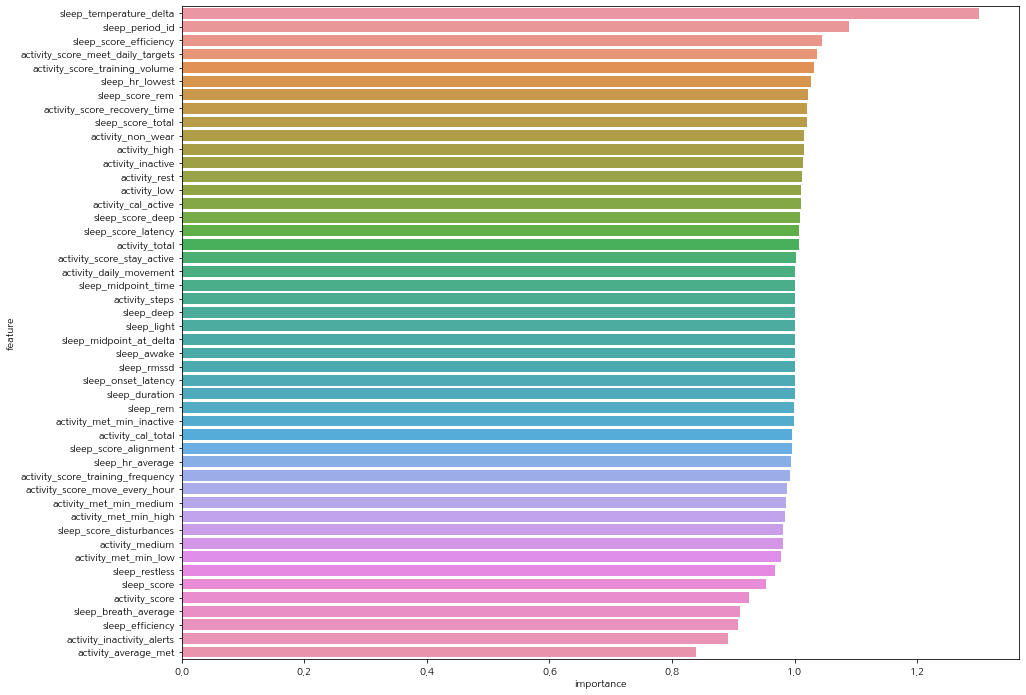

In [16]:
feature_importance_lr = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_lr["importance"] = pow(math.e, w)
feature_importance_lr = feature_importance_lr.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_lr, x="importance", y="feature")

In [215]:
# feature importance 가 1 이하인 것들을 제거해보고 진행해봅니다 
# 23개의 feature가 drop 되고 48개에서 25개만 남게 되겠네요
not_necessary = feature_importance[feature_importance["importance"]<1]["feature"].values
print(len(not_necessary))
print(not_necessary)

25
['activity_score_recovery_time' 'sleep_score_efficiency' 'activity_score'
 'sleep_rem' 'activity_met_min_inactive' 'activity_score_move_every_hour'
 'activity_inactivity_alerts' 'sleep_onset_latency'
 'activity_score_training_volume' 'sleep_breath_average'
 'sleep_score_total' 'sleep_score' 'activity_cal_total' 'sleep_deep'
 'activity_score_training_frequency' 'sleep_score_alignment'
 'activity_met_min_high' 'activity_score_stay_active'
 'sleep_score_disturbances' 'activity_rest' 'sleep_restless'
 'activity_inactive' 'activity_cal_active' 'sleep_duration'
 'activity_total']


feature selection 끝! 

In [216]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)
input_data_X2.head()

,activity_average_met,activity_daily_movement,activity_high,activity_low,activity_medium,activity_met_min_low,activity_met_min_medium,activity_non_wear,activity_score_meet_daily_targets,activity_steps,...,sleep_hr_lowest,sleep_light,sleep_midpoint_at_delta,sleep_midpoint_time,sleep_period_id,sleep_rmssd,sleep_score_deep,sleep_score_latency,sleep_score_rem,sleep_temperature_delta
0,1.285714,0.668473,-0.5,1.658537,0.075683,1.253033,0.155530,0.428226,0.000,0.583640,...,0.777778,0.070707,-0.251153,0.630872,-1.0,-0.762422,-0.807365,0.750000,0.188679,-0.342857
1,-0.142857,-0.233596,-0.5,0.725610,-1.076056,0.483671,-1.065624,0.406597,-0.425,-0.277080,...,0.888889,-0.404040,0.305631,-0.664430,-1.0,-0.857935,-0.754485,0.479167,-0.396226,-0.914286
2,0.142857,-0.080035,-0.5,0.542683,-0.373133,0.432317,-0.328072,0.157293,0.000,-0.189502,...,0.444444,0.196970,-0.434795,0.671141,-1.0,-0.270445,-0.684608,0.342391,-0.283019,0.200000
3,-5.000000,-3.066443,-0.5,-1.457317,-2.110900,-3.125917,-2.267144,0.314586,0.000,-0.221490,...,0.222222,0.292929,-0.170901,0.288591,-1.0,0.000000,-0.857413,0.222826,-0.509434,-1.171429
4,0.142857,-0.322668,-0.5,0.634146,-1.248967,0.432317,-1.211927,0.314586,0.000,-0.336994,...,0.555556,-0.101010,-0.347221,0.617450,-1.0,-0.501019,-0.609065,-0.886651,-0.037736,-0.771429


In [217]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [218]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6508510923468704
0.6484458735262594


중요도 낮은 feature를 pca로 묶어버리기 

In [200]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(input_data_X[not_necessary])
pca_data = pd.DataFrame(pca_data)

input_data_X = input_data_X.drop(not_necessary, axis=1)
input_data_X = pd.concat([input_data_X, pca_data], axis=1)
input_data_X

,activity_cal_active,activity_daily_movement,activity_high,activity_inactive,activity_low,activity_non_wear,activity_rest,activity_score_meet_daily_targets,activity_score_recovery_time,activity_score_stay_active,...,sleep_score_deep,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3
0,730,14346,0,417,545,32,399,95,100,86,...,41,27,97,66,62,-0.12,8745.781720,5205.146185,-2217.055436,-129.982015
1,342,6352,0,473,392,29,538,78,100,83,...,49,46,91,35,44,-0.32,-3666.413467,3478.161454,-1003.884596,-135.760461
2,401,7297,0,586,362,9,459,95,100,71,...,56,34,89,41,62,0.07,5743.947920,4793.364710,-612.371108,177.677910
3,27,491,0,176,34,19,1210,95,100,74,...,35,44,86,29,56,-0.41,1566.914313,4112.081227,-17.252671,306.445278
4,333,5861,0,646,377,19,392,95,100,65,...,64,39,14,54,59,-0.27,3812.479386,3925.581880,-1457.715594,2411.314682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,227,3863,3,735,155,0,530,43,100,49,...,53,74,97,84,82,-0.16,3776.910422,-1090.990063,-861.533231,52.362351
9323,249,4411,1,780,167,0,470,25,100,45,...,34,76,81,95,86,-0.09,4314.371906,-1928.102964,-1195.039789,-303.342512
9324,570,11057,1,518,332,0,528,43,100,76,...,1,69,86,89,64,0.41,-1081.506508,-598.825466,-2319.799570,-185.272605
9325,295,5135,4,578,173,0,655,25,100,70,...,9,86,89,98,97,0.27,6146.706837,-3876.112537,-1455.732410,417.369144


In [201]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.6629138185229861
0.662379421221865


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Decision Tree 

In [145]:
model_dt = DecisionTreeClassifier()

In [146]:
model_dt.fit(tr_val_X, tr_val_y)

DecisionTreeClassifier()

In [ ]:
export_graphviz(
    model_dt,
    out_file='tree.dot')

# 예측한 모형 png로 바꿔서 시각화 하기
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

### Random Forest

In [11]:
model_rf = RandomForestClassifier()

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4843,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6454,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5523,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5275,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5526199999999999


여기서 predict prob 해라 

In [19]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1194
           1       0.94      0.83      0.88       129
           2       0.93      0.70      0.80       543

    accuracy                           0.88      1866
   macro avg       0.91      0.84      0.87      1866
weighted avg       0.89      0.88      0.88      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

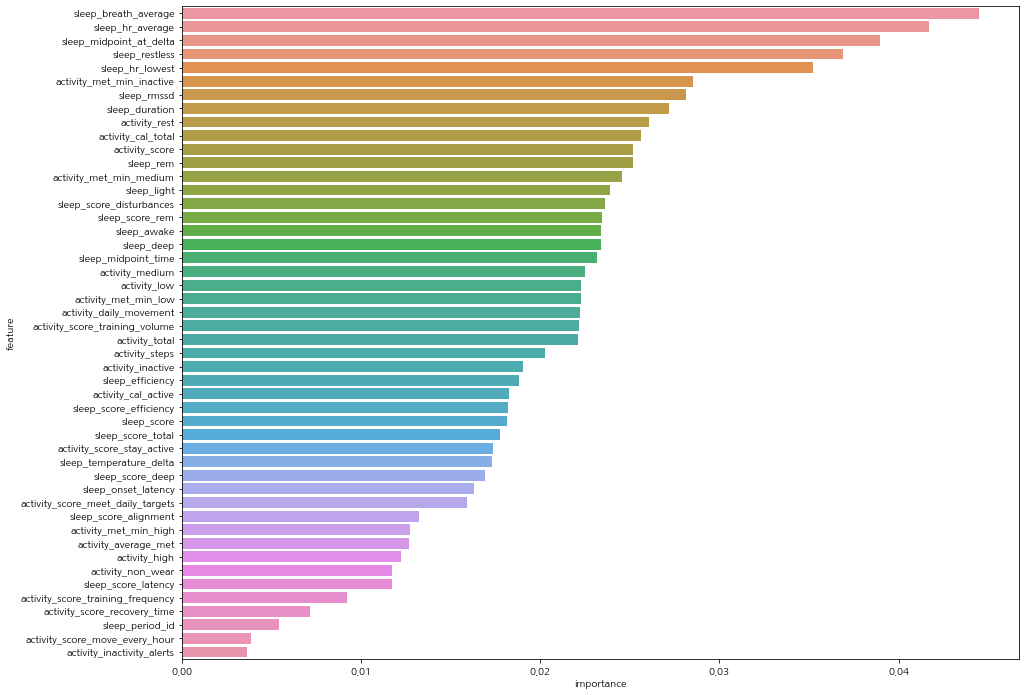

In [20]:
# RF, DT의 feature importance 는 Gini Impurity 기반의 것만 제공합니다 
feature_importance_rf = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_rf["importance"] = model_rf.feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_rf, x="importance", y="feature")

In [67]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_efficiency' 'sleep_score_efficiency' 'sleep_temperature_delta'
 'sleep_score' 'sleep_score_deep' 'sleep_onset_latency'
 'activity_score_meet_daily_targets' 'activity_average_met'
 'activity_met_min_high' 'activity_non_wear' 'sleep_score_alignment'
 'activity_high' 'sleep_score_latency' 'activity_score_training_frequency'
 'activity_score_recovery_time' 'sleep_period_id'
 'activity_inactivity_alerts' 'activity_score_move_every_hour']


In [74]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [76]:
model_rf2 = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf2.fit(x_train, y_train)
    pred = model_rf2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4863,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6588,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5744,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5583,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5308,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.56172


In [77]:
pred_rf = model_rf2.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.93      0.83      0.88       129
           2       0.90      0.71      0.79       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



### AdaBoost

In [21]:
model_ab = AdaBoostClassifier()

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_ab.fit(x_train, y_train)
    pred = model_ab.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.5338,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.4732,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5362,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5114,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.4739,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5057


In [23]:
pred_ab = model_ab.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1194
           1       0.94      0.83      0.88       129
           2       0.93      0.70      0.80       543

    accuracy                           0.88      1866
   macro avg       0.91      0.84      0.87      1866
weighted avg       0.89      0.88      0.88      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

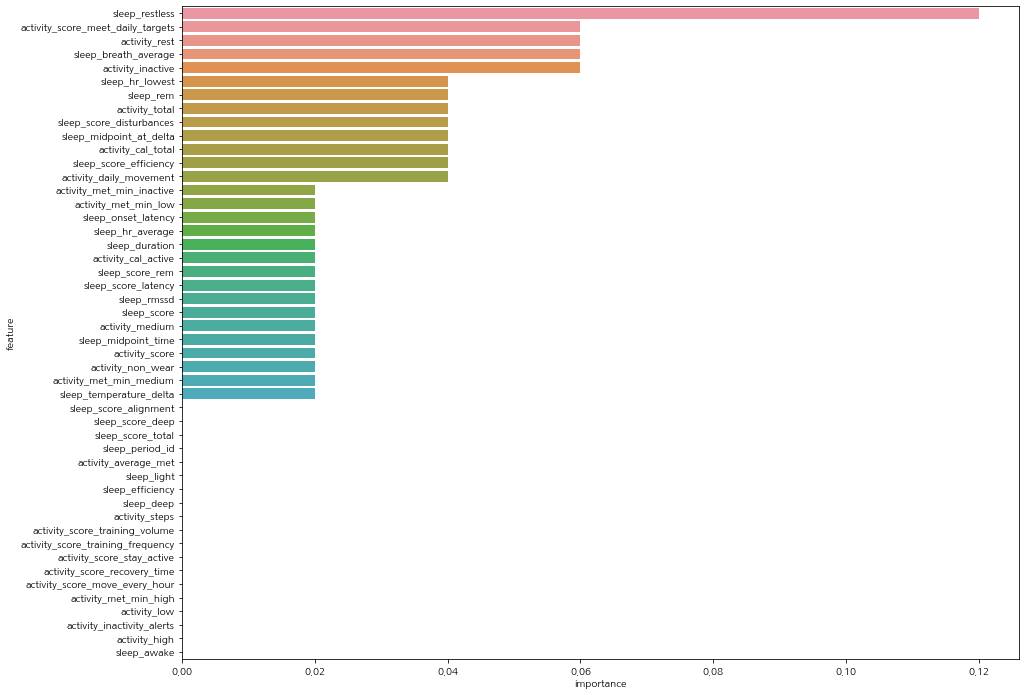

In [24]:
feature_importance_ab = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_ab["importance"] = model_ab.feature_importances_
feature_importance_ab = feature_importance_ab.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_ab, x="importance", y="feature")

In [221]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_score_deep' 'sleep_score_total' 'sleep_period_id'
 'activity_average_met' 'sleep_light' 'sleep_efficiency' 'sleep_deep'
 'activity_steps' 'activity_score_training_volume'
 'activity_score_training_frequency' 'activity_score_stay_active'
 'activity_score_recovery_time' 'activity_score_move_every_hour'
 'activity_met_min_high' 'activity_low' 'activity_inactivity_alerts'
 'activity_high' 'sleep_awake']


In [222]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [223]:
model_ab2 = AdaBoostClassifier()

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_ab2.fit(x_train, y_train)
    pred = model_ab2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.5687,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.4765,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5483,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.508,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.4739,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.51508


In [224]:
pred_ab = model_ab2.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.93      0.83      0.88       129
           2       0.90      0.71      0.79       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



### XGB

In [25]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#4 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.53868


In [27]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

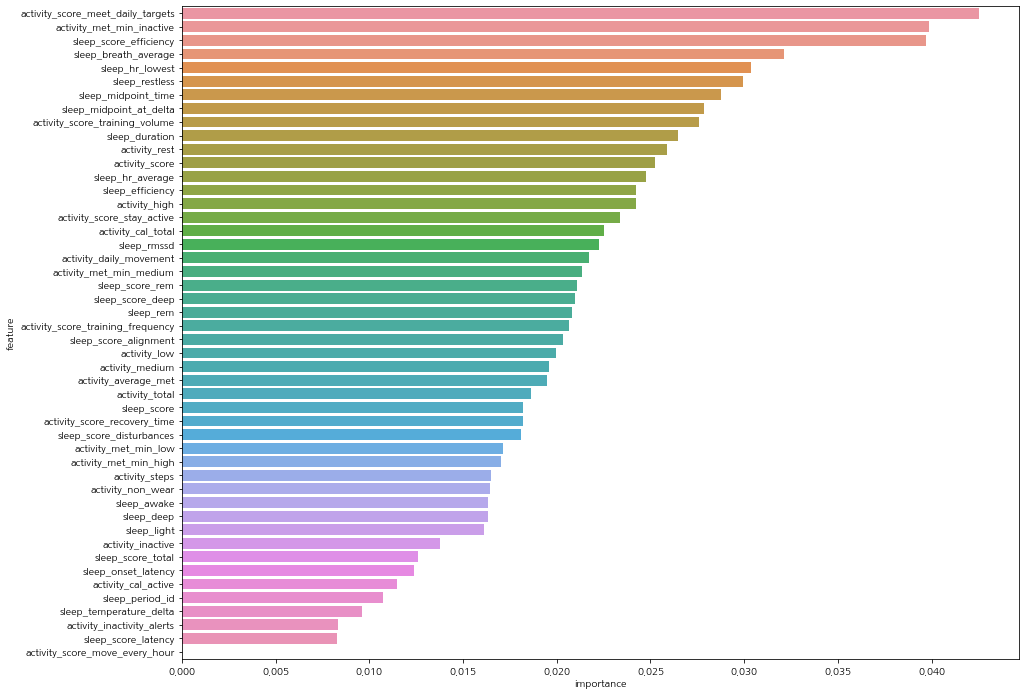

In [28]:
# XGB, LGBM과 같은 Gradient Boosting 계열의 모델은 feature importance를 계산하는 여러가지 option이 존재
# default 는 gain/total gain 
# gain/total gain : featur가 모델 예측에 어느정도 영향을 미쳤는가를 측정하는 방법
# 특정 feature로 분기되었을 때 얻는 성능 상의 이득을 계산 (gini impurity와 비슷)
# 이밖의 option -> cover/total cover, weight 
# 자세한 것은 https://hongl.tistory.com/131
feature_importance_xgb = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_xgb["importance"] = model_xgb.feature_importances_
feature_importance_xgb = feature_importance_xgb.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_xgb, x="importance", y="feature")

In [95]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['activity_score_recovery_time' 'sleep_score_disturbances'
 'activity_met_min_low' 'activity_met_min_high' 'activity_steps'
 'activity_non_wear' 'sleep_awake' 'sleep_deep' 'sleep_light'
 'activity_inactive' 'sleep_score_total' 'sleep_onset_latency'
 'activity_cal_active' 'sleep_period_id' 'sleep_temperature_delta'
 'activity_inactivity_alerts' 'sleep_score_latency'
 'activity_score_move_every_hour']


In [96]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [97]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#1 교차 검증 정확도 : 0.4802,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#2 교차 검증 정확도 : 0.6394,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#3 교차 검증 정확도 : 0.5282,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#4 교차 검증 정확도 : 0.5389,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#5 교차 검증 정확도 : 0.5302,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.54338


In [98]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1194
           1       0.87      0.88      0.87       129
           2       0.84      0.73      0.78       543

    accuracy                           0.87      1866
   macro avg       0.86      0.85      0.85      1866
weighted avg       0.87      0.87      0.87      1866



### LGBM

In [29]:
model_lgbm = LGBMClassifier()

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5349,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5436,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5295,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5460800000000001


In [31]:
pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.86      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

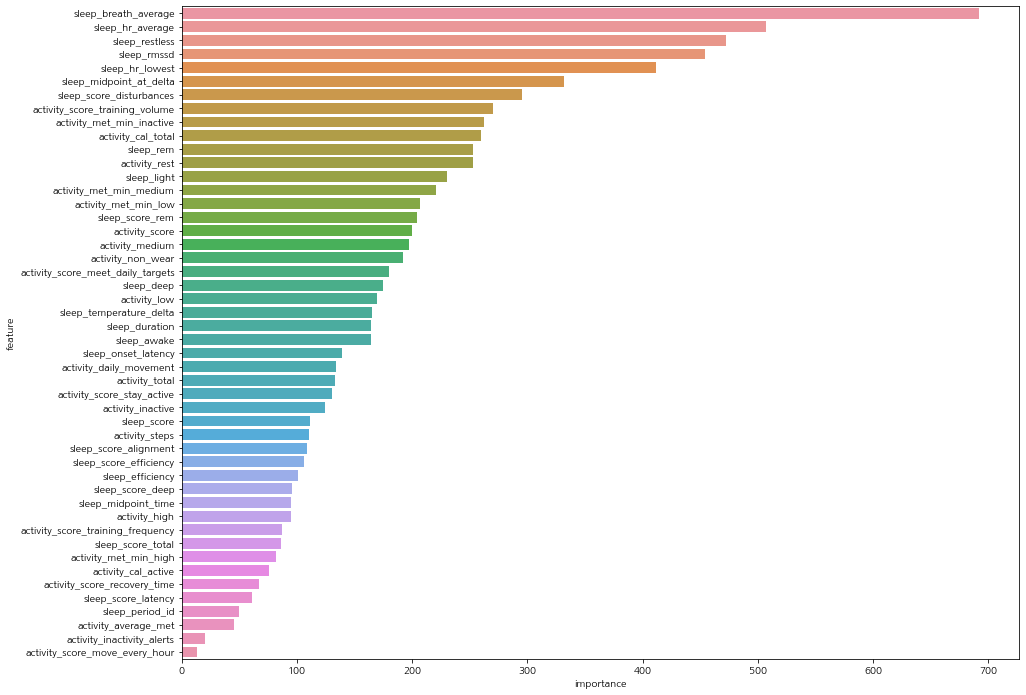

In [32]:
feature_importance_lgbm = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_lgbm["importance"] = model_lgbm.feature_importances_
feature_importance_lgbm = feature_importance_lgbm.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_lgbm, x="importance", y="feature")

In [109]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_score' 'activity_steps' 'sleep_score_alignment'
 'sleep_score_efficiency' 'sleep_efficiency' 'sleep_score_deep'
 'sleep_midpoint_time' 'activity_high' 'activity_score_training_frequency'
 'sleep_score_total' 'activity_met_min_high' 'activity_cal_active'
 'activity_score_recovery_time' 'sleep_score_latency' 'sleep_period_id'
 'activity_average_met' 'activity_inactivity_alerts'
 'activity_score_move_every_hour']


In [110]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [111]:
model_lgbm2 = LGBMClassifier()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm2.fit(x_train, y_train)
    pred = model_lgbm2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4836,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5355,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.559,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5315,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.55088


In [112]:
pred_lgbm_prob = model_lgbm2.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90      1194
           1       0.87      0.87      0.87       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



### CatBoost

In [33]:
# Categorical 범주에 적잡한 알고리즘 
# 수치형 변수가 많다면 lightGBM보다 학습 속도가느릴 수 있음 
model_cat = CatBoostClassifier()

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_cat.fit(x_train, y_train)
    pred = model_cat.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.086674
0:	learn: 1.0507875	total: 170ms	remaining: 2m 50s
1:	learn: 1.0120067	total: 184ms	remaining: 1m 31s
2:	learn: 0.9757200	total: 198ms	remaining: 1m 5s
3:	learn: 0.9452100	total: 210ms	remaining: 52.4s
4:	learn: 0.9175665	total: 221ms	remaining: 44.1s
5:	learn: 0.8932527	total: 232ms	remaining: 38.5s
6:	learn: 0.8738848	total: 245ms	remaining: 34.7s
7:	learn: 0.8537387	total: 256ms	remaining: 31.7s
8:	learn: 0.8351611	total: 266ms	remaining: 29.3s
9:	learn: 0.8181381	total: 277ms	remaining: 27.5s
10:	learn: 0.8018156	total: 289ms	remaining: 25.9s
11:	learn: 0.7888478	total: 300ms	remaining: 24.7s
12:	learn: 0.7765993	total: 311ms	remaining: 23.6s
13:	learn: 0.7644760	total: 323ms	remaining: 22.8s
14:	learn: 0.7564929	total: 338ms	remaining: 22.2s
15:	learn: 0.7459093	total: 349ms	remaining: 21.5s
16:	learn: 0.7368455	total: 374ms	remaining: 21.6s
17:	learn: 0.7261270	total: 386ms	remaining: 21.1s
18:	learn: 0.7178481	total: 401ms	remaining: 20.7s
19:	learn

166:	learn: 0.3470292	total: 2.21s	remaining: 11s
167:	learn: 0.3459730	total: 2.23s	remaining: 11s
168:	learn: 0.3442999	total: 2.24s	remaining: 11s
169:	learn: 0.3431858	total: 2.26s	remaining: 11s
170:	learn: 0.3422828	total: 2.27s	remaining: 11s
171:	learn: 0.3402830	total: 2.29s	remaining: 11s
172:	learn: 0.3395476	total: 2.31s	remaining: 11s
173:	learn: 0.3384492	total: 2.32s	remaining: 11s
174:	learn: 0.3375206	total: 2.33s	remaining: 11s
175:	learn: 0.3368017	total: 2.35s	remaining: 11s
176:	learn: 0.3352265	total: 2.36s	remaining: 11s
177:	learn: 0.3333464	total: 2.38s	remaining: 11s
178:	learn: 0.3324499	total: 2.39s	remaining: 11s
179:	learn: 0.3312028	total: 2.4s	remaining: 11s
180:	learn: 0.3302624	total: 2.42s	remaining: 10.9s
181:	learn: 0.3295199	total: 2.43s	remaining: 10.9s
182:	learn: 0.3285030	total: 2.44s	remaining: 10.9s
183:	learn: 0.3274034	total: 2.46s	remaining: 10.9s
184:	learn: 0.3265703	total: 2.48s	remaining: 10.9s
185:	learn: 0.3257950	total: 2.5s	remaini

335:	learn: 0.2234821	total: 4.4s	remaining: 8.7s
336:	learn: 0.2230813	total: 4.42s	remaining: 8.69s
337:	learn: 0.2226362	total: 4.43s	remaining: 8.68s
338:	learn: 0.2224844	total: 4.44s	remaining: 8.66s
339:	learn: 0.2220813	total: 4.45s	remaining: 8.64s
340:	learn: 0.2214039	total: 4.46s	remaining: 8.62s
341:	learn: 0.2206780	total: 4.47s	remaining: 8.61s
342:	learn: 0.2202972	total: 4.49s	remaining: 8.59s
343:	learn: 0.2194078	total: 4.5s	remaining: 8.58s
344:	learn: 0.2189084	total: 4.52s	remaining: 8.57s
345:	learn: 0.2184235	total: 4.53s	remaining: 8.56s
346:	learn: 0.2180149	total: 4.54s	remaining: 8.54s
347:	learn: 0.2172524	total: 4.55s	remaining: 8.53s
348:	learn: 0.2166607	total: 4.56s	remaining: 8.51s
349:	learn: 0.2161510	total: 4.58s	remaining: 8.5s
350:	learn: 0.2159174	total: 4.59s	remaining: 8.48s
351:	learn: 0.2155018	total: 4.61s	remaining: 8.48s
352:	learn: 0.2151652	total: 4.62s	remaining: 8.46s
353:	learn: 0.2149674	total: 4.63s	remaining: 8.45s
354:	learn: 0.21

508:	learn: 0.1591370	total: 6.63s	remaining: 6.4s
509:	learn: 0.1589197	total: 6.65s	remaining: 6.38s
510:	learn: 0.1587397	total: 6.66s	remaining: 6.37s
511:	learn: 0.1584898	total: 6.67s	remaining: 6.36s
512:	learn: 0.1580626	total: 6.68s	remaining: 6.34s
513:	learn: 0.1579107	total: 6.69s	remaining: 6.33s
514:	learn: 0.1575696	total: 6.71s	remaining: 6.32s
515:	learn: 0.1573029	total: 6.72s	remaining: 6.3s
516:	learn: 0.1569536	total: 6.73s	remaining: 6.29s
517:	learn: 0.1567601	total: 6.74s	remaining: 6.28s
518:	learn: 0.1564439	total: 6.75s	remaining: 6.26s
519:	learn: 0.1560901	total: 6.77s	remaining: 6.25s
520:	learn: 0.1558592	total: 6.78s	remaining: 6.23s
521:	learn: 0.1555122	total: 6.79s	remaining: 6.22s
522:	learn: 0.1552998	total: 6.81s	remaining: 6.21s
523:	learn: 0.1550453	total: 6.82s	remaining: 6.2s
524:	learn: 0.1548107	total: 6.83s	remaining: 6.18s
525:	learn: 0.1545657	total: 6.85s	remaining: 6.17s
526:	learn: 0.1543827	total: 6.86s	remaining: 6.16s
527:	learn: 0.1

679:	learn: 0.1212269	total: 8.87s	remaining: 4.17s
680:	learn: 0.1210843	total: 8.89s	remaining: 4.16s
681:	learn: 0.1209081	total: 8.91s	remaining: 4.15s
682:	learn: 0.1207028	total: 8.92s	remaining: 4.14s
683:	learn: 0.1204061	total: 8.94s	remaining: 4.13s
684:	learn: 0.1200648	total: 8.96s	remaining: 4.12s
685:	learn: 0.1199697	total: 8.98s	remaining: 4.11s
686:	learn: 0.1196731	total: 8.99s	remaining: 4.1s
687:	learn: 0.1194106	total: 9.01s	remaining: 4.08s
688:	learn: 0.1192759	total: 9.02s	remaining: 4.07s
689:	learn: 0.1191424	total: 9.04s	remaining: 4.06s
690:	learn: 0.1190223	total: 9.05s	remaining: 4.05s
691:	learn: 0.1187305	total: 9.06s	remaining: 4.04s
692:	learn: 0.1186174	total: 9.09s	remaining: 4.03s
693:	learn: 0.1183834	total: 9.11s	remaining: 4.01s
694:	learn: 0.1181794	total: 9.12s	remaining: 4s
695:	learn: 0.1180253	total: 9.13s	remaining: 3.99s
696:	learn: 0.1178152	total: 9.15s	remaining: 3.98s
697:	learn: 0.1177330	total: 9.17s	remaining: 3.97s
698:	learn: 0.11

839:	learn: 0.0960916	total: 11.1s	remaining: 2.11s
840:	learn: 0.0959892	total: 11.1s	remaining: 2.1s
841:	learn: 0.0958148	total: 11.1s	remaining: 2.08s
842:	learn: 0.0956911	total: 11.1s	remaining: 2.07s
843:	learn: 0.0956208	total: 11.1s	remaining: 2.06s
844:	learn: 0.0954037	total: 11.1s	remaining: 2.04s
845:	learn: 0.0952609	total: 11.1s	remaining: 2.03s
846:	learn: 0.0951314	total: 11.2s	remaining: 2.02s
847:	learn: 0.0949931	total: 11.2s	remaining: 2s
848:	learn: 0.0949409	total: 11.2s	remaining: 1.99s
849:	learn: 0.0948865	total: 11.2s	remaining: 1.98s
850:	learn: 0.0947735	total: 11.2s	remaining: 1.97s
851:	learn: 0.0946691	total: 11.2s	remaining: 1.95s
852:	learn: 0.0945912	total: 11.3s	remaining: 1.94s
853:	learn: 0.0944864	total: 11.3s	remaining: 1.93s
854:	learn: 0.0943353	total: 11.3s	remaining: 1.91s
855:	learn: 0.0942625	total: 11.3s	remaining: 1.9s
856:	learn: 0.0941599	total: 11.3s	remaining: 1.89s
857:	learn: 0.0940379	total: 11.3s	remaining: 1.87s
858:	learn: 0.093

0:	learn: 1.0572413	total: 26.1ms	remaining: 26.1s
1:	learn: 1.0207846	total: 42.1ms	remaining: 21s
2:	learn: 0.9882655	total: 52.4ms	remaining: 17.4s
3:	learn: 0.9588894	total: 66.3ms	remaining: 16.5s
4:	learn: 0.9339698	total: 83.8ms	remaining: 16.7s
5:	learn: 0.9121008	total: 96ms	remaining: 15.9s
6:	learn: 0.8910482	total: 108ms	remaining: 15.3s
7:	learn: 0.8724464	total: 119ms	remaining: 14.8s
8:	learn: 0.8554413	total: 131ms	remaining: 14.4s
9:	learn: 0.8379067	total: 144ms	remaining: 14.3s
10:	learn: 0.8216732	total: 157ms	remaining: 14.1s
11:	learn: 0.8087433	total: 172ms	remaining: 14.2s
12:	learn: 0.7975623	total: 183ms	remaining: 13.9s
13:	learn: 0.7853418	total: 195ms	remaining: 13.8s
14:	learn: 0.7761563	total: 207ms	remaining: 13.6s
15:	learn: 0.7652732	total: 223ms	remaining: 13.7s
16:	learn: 0.7555368	total: 234ms	remaining: 13.5s
17:	learn: 0.7448041	total: 245ms	remaining: 13.4s
18:	learn: 0.7344637	total: 261ms	remaining: 13.5s
19:	learn: 0.7284717	total: 275ms	remai

170:	learn: 0.3534186	total: 2.22s	remaining: 10.8s
171:	learn: 0.3525339	total: 2.24s	remaining: 10.8s
172:	learn: 0.3514399	total: 2.25s	remaining: 10.8s
173:	learn: 0.3506710	total: 2.27s	remaining: 10.8s
174:	learn: 0.3499629	total: 2.28s	remaining: 10.7s
175:	learn: 0.3489745	total: 2.29s	remaining: 10.7s
176:	learn: 0.3482342	total: 2.31s	remaining: 10.8s
177:	learn: 0.3468628	total: 2.33s	remaining: 10.8s
178:	learn: 0.3459891	total: 2.34s	remaining: 10.7s
179:	learn: 0.3446909	total: 2.35s	remaining: 10.7s
180:	learn: 0.3436695	total: 2.36s	remaining: 10.7s
181:	learn: 0.3429761	total: 2.37s	remaining: 10.7s
182:	learn: 0.3418357	total: 2.38s	remaining: 10.6s
183:	learn: 0.3409417	total: 2.4s	remaining: 10.6s
184:	learn: 0.3399158	total: 2.41s	remaining: 10.6s
185:	learn: 0.3385593	total: 2.42s	remaining: 10.6s
186:	learn: 0.3372480	total: 2.43s	remaining: 10.6s
187:	learn: 0.3357953	total: 2.44s	remaining: 10.6s
188:	learn: 0.3350758	total: 2.46s	remaining: 10.5s
189:	learn: 0

342:	learn: 0.2312542	total: 4.42s	remaining: 8.46s
343:	learn: 0.2303747	total: 4.43s	remaining: 8.45s
344:	learn: 0.2298108	total: 4.46s	remaining: 8.46s
345:	learn: 0.2291116	total: 4.48s	remaining: 8.47s
346:	learn: 0.2286917	total: 4.5s	remaining: 8.46s
347:	learn: 0.2282103	total: 4.51s	remaining: 8.45s
348:	learn: 0.2275714	total: 4.52s	remaining: 8.44s
349:	learn: 0.2272024	total: 4.54s	remaining: 8.43s
350:	learn: 0.2268610	total: 4.55s	remaining: 8.42s
351:	learn: 0.2264771	total: 4.57s	remaining: 8.41s
352:	learn: 0.2262314	total: 4.58s	remaining: 8.39s
353:	learn: 0.2258471	total: 4.59s	remaining: 8.39s
354:	learn: 0.2253756	total: 4.61s	remaining: 8.37s
355:	learn: 0.2249472	total: 4.62s	remaining: 8.35s
356:	learn: 0.2244641	total: 4.63s	remaining: 8.34s
357:	learn: 0.2239287	total: 4.64s	remaining: 8.32s
358:	learn: 0.2237123	total: 4.65s	remaining: 8.31s
359:	learn: 0.2231679	total: 4.66s	remaining: 8.29s
360:	learn: 0.2226908	total: 4.67s	remaining: 8.27s
361:	learn: 0

516:	learn: 0.1693776	total: 6.58s	remaining: 6.15s
517:	learn: 0.1691095	total: 6.6s	remaining: 6.14s
518:	learn: 0.1686423	total: 6.62s	remaining: 6.13s
519:	learn: 0.1684715	total: 6.63s	remaining: 6.12s
520:	learn: 0.1683100	total: 6.64s	remaining: 6.1s
521:	learn: 0.1680180	total: 6.65s	remaining: 6.09s
522:	learn: 0.1675157	total: 6.66s	remaining: 6.08s
523:	learn: 0.1673725	total: 6.68s	remaining: 6.07s
524:	learn: 0.1671564	total: 6.69s	remaining: 6.05s
525:	learn: 0.1668955	total: 6.7s	remaining: 6.04s
526:	learn: 0.1667076	total: 6.71s	remaining: 6.03s
527:	learn: 0.1665153	total: 6.73s	remaining: 6.01s
528:	learn: 0.1663841	total: 6.74s	remaining: 6s
529:	learn: 0.1661617	total: 6.75s	remaining: 5.99s
530:	learn: 0.1660014	total: 6.76s	remaining: 5.97s
531:	learn: 0.1658114	total: 6.78s	remaining: 5.96s
532:	learn: 0.1655080	total: 6.79s	remaining: 5.95s
533:	learn: 0.1652352	total: 6.8s	remaining: 5.94s
534:	learn: 0.1649492	total: 6.82s	remaining: 5.92s
535:	learn: 0.16462

683:	learn: 0.1305547	total: 8.8s	remaining: 4.07s
684:	learn: 0.1303544	total: 8.83s	remaining: 4.06s
685:	learn: 0.1302220	total: 8.85s	remaining: 4.05s
686:	learn: 0.1300881	total: 8.86s	remaining: 4.04s
687:	learn: 0.1298653	total: 8.88s	remaining: 4.03s
688:	learn: 0.1297307	total: 8.89s	remaining: 4.01s
689:	learn: 0.1295879	total: 8.9s	remaining: 4s
690:	learn: 0.1294240	total: 8.92s	remaining: 3.99s
691:	learn: 0.1291010	total: 8.93s	remaining: 3.98s
692:	learn: 0.1288514	total: 8.95s	remaining: 3.96s
693:	learn: 0.1286668	total: 8.96s	remaining: 3.95s
694:	learn: 0.1284334	total: 8.98s	remaining: 3.94s
695:	learn: 0.1282611	total: 8.99s	remaining: 3.93s
696:	learn: 0.1281373	total: 9.02s	remaining: 3.92s
697:	learn: 0.1280019	total: 9.03s	remaining: 3.91s
698:	learn: 0.1278148	total: 9.04s	remaining: 3.89s
699:	learn: 0.1275682	total: 9.06s	remaining: 3.88s
700:	learn: 0.1274677	total: 9.07s	remaining: 3.87s
701:	learn: 0.1273447	total: 9.09s	remaining: 3.86s
702:	learn: 0.127

851:	learn: 0.1031780	total: 11s	remaining: 1.91s
852:	learn: 0.1031109	total: 11s	remaining: 1.9s
853:	learn: 0.1030159	total: 11s	remaining: 1.88s
854:	learn: 0.1028477	total: 11s	remaining: 1.87s
855:	learn: 0.1026821	total: 11s	remaining: 1.86s
856:	learn: 0.1024875	total: 11.1s	remaining: 1.84s
857:	learn: 0.1024027	total: 11.1s	remaining: 1.83s
858:	learn: 0.1021971	total: 11.1s	remaining: 1.82s
859:	learn: 0.1020498	total: 11.1s	remaining: 1.8s
860:	learn: 0.1019281	total: 11.1s	remaining: 1.79s
861:	learn: 0.1016668	total: 11.1s	remaining: 1.78s
862:	learn: 0.1015841	total: 11.1s	remaining: 1.76s
863:	learn: 0.1014994	total: 11.1s	remaining: 1.75s
864:	learn: 0.1014170	total: 11.1s	remaining: 1.74s
865:	learn: 0.1011228	total: 11.2s	remaining: 1.73s
866:	learn: 0.1010073	total: 11.2s	remaining: 1.71s
867:	learn: 0.1008670	total: 11.2s	remaining: 1.7s
868:	learn: 0.1007030	total: 11.2s	remaining: 1.69s
869:	learn: 0.1006258	total: 11.2s	remaining: 1.67s
870:	learn: 0.1005182	tot

16:	learn: 0.7203398	total: 224ms	remaining: 12.9s
17:	learn: 0.7121462	total: 239ms	remaining: 13s
18:	learn: 0.7039491	total: 251ms	remaining: 12.9s
19:	learn: 0.6945487	total: 265ms	remaining: 13s
20:	learn: 0.6881477	total: 279ms	remaining: 13s
21:	learn: 0.6789820	total: 291ms	remaining: 12.9s
22:	learn: 0.6715202	total: 304ms	remaining: 12.9s
23:	learn: 0.6638608	total: 314ms	remaining: 12.8s
24:	learn: 0.6581227	total: 325ms	remaining: 12.7s
25:	learn: 0.6495600	total: 338ms	remaining: 12.6s
26:	learn: 0.6437704	total: 348ms	remaining: 12.5s
27:	learn: 0.6389095	total: 360ms	remaining: 12.5s
28:	learn: 0.6305370	total: 372ms	remaining: 12.4s
29:	learn: 0.6249028	total: 382ms	remaining: 12.4s
30:	learn: 0.6205573	total: 395ms	remaining: 12.3s
31:	learn: 0.6156813	total: 405ms	remaining: 12.3s
32:	learn: 0.6113101	total: 416ms	remaining: 12.2s
33:	learn: 0.6075156	total: 432ms	remaining: 12.3s
34:	learn: 0.6023222	total: 443ms	remaining: 12.2s
35:	learn: 0.5981492	total: 454ms	rem

188:	learn: 0.3046244	total: 2.38s	remaining: 10.2s
189:	learn: 0.3037943	total: 2.39s	remaining: 10.2s
190:	learn: 0.3030439	total: 2.4s	remaining: 10.2s
191:	learn: 0.3022067	total: 2.41s	remaining: 10.2s
192:	learn: 0.3013265	total: 2.42s	remaining: 10.1s
193:	learn: 0.3002852	total: 2.44s	remaining: 10.1s
194:	learn: 0.2995760	total: 2.45s	remaining: 10.1s
195:	learn: 0.2988810	total: 2.46s	remaining: 10.1s
196:	learn: 0.2980984	total: 2.48s	remaining: 10.1s
197:	learn: 0.2967903	total: 2.49s	remaining: 10.1s
198:	learn: 0.2961531	total: 2.5s	remaining: 10.1s
199:	learn: 0.2950088	total: 2.51s	remaining: 10s
200:	learn: 0.2938124	total: 2.52s	remaining: 10s
201:	learn: 0.2929636	total: 2.53s	remaining: 10s
202:	learn: 0.2925815	total: 2.54s	remaining: 9.99s
203:	learn: 0.2922845	total: 2.56s	remaining: 9.97s
204:	learn: 0.2912826	total: 2.57s	remaining: 9.96s
205:	learn: 0.2903367	total: 2.58s	remaining: 9.95s
206:	learn: 0.2892598	total: 2.6s	remaining: 9.95s
207:	learn: 0.2885720

348:	learn: 0.2067285	total: 4.38s	remaining: 8.18s
349:	learn: 0.2062263	total: 4.4s	remaining: 8.17s
350:	learn: 0.2058384	total: 4.42s	remaining: 8.18s
351:	learn: 0.2054291	total: 4.43s	remaining: 8.16s
352:	learn: 0.2048100	total: 4.45s	remaining: 8.15s
353:	learn: 0.2043476	total: 4.46s	remaining: 8.13s
354:	learn: 0.2039025	total: 4.47s	remaining: 8.13s
355:	learn: 0.2034066	total: 4.49s	remaining: 8.12s
356:	learn: 0.2031387	total: 4.5s	remaining: 8.12s
357:	learn: 0.2028488	total: 4.52s	remaining: 8.11s
358:	learn: 0.2026920	total: 4.53s	remaining: 8.09s
359:	learn: 0.2023268	total: 4.55s	remaining: 8.09s
360:	learn: 0.2021243	total: 4.56s	remaining: 8.07s
361:	learn: 0.2014170	total: 4.58s	remaining: 8.06s
362:	learn: 0.2010701	total: 4.59s	remaining: 8.05s
363:	learn: 0.2001906	total: 4.6s	remaining: 8.04s
364:	learn: 0.1993081	total: 4.62s	remaining: 8.03s
365:	learn: 0.1986863	total: 4.63s	remaining: 8.02s
366:	learn: 0.1978522	total: 4.64s	remaining: 8s
367:	learn: 0.1976

507:	learn: 0.1508953	total: 6.38s	remaining: 6.17s
508:	learn: 0.1507629	total: 6.39s	remaining: 6.16s
509:	learn: 0.1506070	total: 6.4s	remaining: 6.15s
510:	learn: 0.1504057	total: 6.41s	remaining: 6.13s
511:	learn: 0.1501878	total: 6.42s	remaining: 6.12s
512:	learn: 0.1498143	total: 6.43s	remaining: 6.11s
513:	learn: 0.1495551	total: 6.45s	remaining: 6.09s
514:	learn: 0.1492773	total: 6.46s	remaining: 6.08s
515:	learn: 0.1490060	total: 6.47s	remaining: 6.07s
516:	learn: 0.1487009	total: 6.48s	remaining: 6.05s
517:	learn: 0.1485972	total: 6.49s	remaining: 6.04s
518:	learn: 0.1484301	total: 6.52s	remaining: 6.04s
519:	learn: 0.1480492	total: 6.53s	remaining: 6.03s
520:	learn: 0.1475391	total: 6.54s	remaining: 6.01s
521:	learn: 0.1471776	total: 6.55s	remaining: 6s
522:	learn: 0.1470198	total: 6.57s	remaining: 5.99s
523:	learn: 0.1467893	total: 6.58s	remaining: 5.98s
524:	learn: 0.1465995	total: 6.59s	remaining: 5.96s
525:	learn: 0.1464915	total: 6.61s	remaining: 5.95s
526:	learn: 0.14

678:	learn: 0.1136593	total: 8.58s	remaining: 4.05s
679:	learn: 0.1135220	total: 8.59s	remaining: 4.04s
680:	learn: 0.1133228	total: 8.6s	remaining: 4.03s
681:	learn: 0.1131564	total: 8.61s	remaining: 4.02s
682:	learn: 0.1130562	total: 8.62s	remaining: 4s
683:	learn: 0.1129329	total: 8.63s	remaining: 3.99s
684:	learn: 0.1126930	total: 8.64s	remaining: 3.98s
685:	learn: 0.1124447	total: 8.66s	remaining: 3.96s
686:	learn: 0.1123495	total: 8.67s	remaining: 3.95s
687:	learn: 0.1121282	total: 8.68s	remaining: 3.94s
688:	learn: 0.1118934	total: 8.69s	remaining: 3.92s
689:	learn: 0.1116270	total: 8.7s	remaining: 3.91s
690:	learn: 0.1114684	total: 8.72s	remaining: 3.9s
691:	learn: 0.1113575	total: 8.73s	remaining: 3.88s
692:	learn: 0.1110120	total: 8.74s	remaining: 3.87s
693:	learn: 0.1109356	total: 8.75s	remaining: 3.86s
694:	learn: 0.1108167	total: 8.76s	remaining: 3.85s
695:	learn: 0.1106765	total: 8.78s	remaining: 3.83s
696:	learn: 0.1105258	total: 8.79s	remaining: 3.82s
697:	learn: 0.1103

848:	learn: 0.0891193	total: 10.6s	remaining: 1.88s
849:	learn: 0.0889740	total: 10.6s	remaining: 1.87s
850:	learn: 0.0888853	total: 10.6s	remaining: 1.85s
851:	learn: 0.0887387	total: 10.6s	remaining: 1.84s
852:	learn: 0.0886289	total: 10.6s	remaining: 1.83s
853:	learn: 0.0885520	total: 10.6s	remaining: 1.82s
854:	learn: 0.0884318	total: 10.6s	remaining: 1.8s
855:	learn: 0.0882510	total: 10.7s	remaining: 1.79s
856:	learn: 0.0881765	total: 10.7s	remaining: 1.78s
857:	learn: 0.0880207	total: 10.7s	remaining: 1.77s
858:	learn: 0.0878844	total: 10.7s	remaining: 1.75s
859:	learn: 0.0877871	total: 10.7s	remaining: 1.74s
860:	learn: 0.0877353	total: 10.7s	remaining: 1.73s
861:	learn: 0.0875804	total: 10.7s	remaining: 1.72s
862:	learn: 0.0874417	total: 10.7s	remaining: 1.7s
863:	learn: 0.0872974	total: 10.7s	remaining: 1.69s
864:	learn: 0.0871450	total: 10.8s	remaining: 1.68s
865:	learn: 0.0870764	total: 10.8s	remaining: 1.67s
866:	learn: 0.0869396	total: 10.8s	remaining: 1.65s
867:	learn: 0.

20:	learn: 0.6940264	total: 248ms	remaining: 11.6s
21:	learn: 0.6867879	total: 261ms	remaining: 11.6s
22:	learn: 0.6802730	total: 272ms	remaining: 11.5s
23:	learn: 0.6734946	total: 283ms	remaining: 11.5s
24:	learn: 0.6678852	total: 294ms	remaining: 11.5s
25:	learn: 0.6628277	total: 305ms	remaining: 11.4s
26:	learn: 0.6574637	total: 315ms	remaining: 11.4s
27:	learn: 0.6513753	total: 326ms	remaining: 11.3s
28:	learn: 0.6460854	total: 337ms	remaining: 11.3s
29:	learn: 0.6422390	total: 349ms	remaining: 11.3s
30:	learn: 0.6391234	total: 359ms	remaining: 11.2s
31:	learn: 0.6357471	total: 370ms	remaining: 11.2s
32:	learn: 0.6311282	total: 381ms	remaining: 11.2s
33:	learn: 0.6272844	total: 395ms	remaining: 11.2s
34:	learn: 0.6216836	total: 406ms	remaining: 11.2s
35:	learn: 0.6190065	total: 418ms	remaining: 11.2s
36:	learn: 0.6160202	total: 429ms	remaining: 11.2s
37:	learn: 0.6135728	total: 444ms	remaining: 11.2s
38:	learn: 0.6102827	total: 456ms	remaining: 11.2s
39:	learn: 0.6055043	total: 467

192:	learn: 0.3286596	total: 2.24s	remaining: 9.37s
193:	learn: 0.3273090	total: 2.25s	remaining: 9.35s
194:	learn: 0.3262619	total: 2.26s	remaining: 9.34s
195:	learn: 0.3257607	total: 2.27s	remaining: 9.32s
196:	learn: 0.3246160	total: 2.28s	remaining: 9.3s
197:	learn: 0.3232554	total: 2.29s	remaining: 9.29s
198:	learn: 0.3224509	total: 2.3s	remaining: 9.28s
199:	learn: 0.3214524	total: 2.31s	remaining: 9.26s
200:	learn: 0.3202734	total: 2.33s	remaining: 9.24s
201:	learn: 0.3194234	total: 2.34s	remaining: 9.24s
202:	learn: 0.3186297	total: 2.35s	remaining: 9.22s
203:	learn: 0.3181714	total: 2.36s	remaining: 9.21s
204:	learn: 0.3169423	total: 2.37s	remaining: 9.19s
205:	learn: 0.3153897	total: 2.38s	remaining: 9.17s
206:	learn: 0.3146914	total: 2.39s	remaining: 9.16s
207:	learn: 0.3137728	total: 2.4s	remaining: 9.15s
208:	learn: 0.3127918	total: 2.41s	remaining: 9.13s
209:	learn: 0.3120315	total: 2.43s	remaining: 9.13s
210:	learn: 0.3112459	total: 2.44s	remaining: 9.12s
211:	learn: 0.3

367:	learn: 0.2150177	total: 4.21s	remaining: 7.23s
368:	learn: 0.2147158	total: 4.22s	remaining: 7.22s
369:	learn: 0.2142221	total: 4.23s	remaining: 7.21s
370:	learn: 0.2136649	total: 4.25s	remaining: 7.2s
371:	learn: 0.2134481	total: 4.26s	remaining: 7.19s
372:	learn: 0.2126598	total: 4.27s	remaining: 7.17s
373:	learn: 0.2123628	total: 4.28s	remaining: 7.16s
374:	learn: 0.2119444	total: 4.29s	remaining: 7.15s
375:	learn: 0.2116290	total: 4.3s	remaining: 7.14s
376:	learn: 0.2112627	total: 4.31s	remaining: 7.13s
377:	learn: 0.2110615	total: 4.32s	remaining: 7.12s
378:	learn: 0.2107158	total: 4.33s	remaining: 7.1s
379:	learn: 0.2104947	total: 4.35s	remaining: 7.09s
380:	learn: 0.2101829	total: 4.36s	remaining: 7.08s
381:	learn: 0.2097405	total: 4.37s	remaining: 7.07s
382:	learn: 0.2093937	total: 4.38s	remaining: 7.06s
383:	learn: 0.2089743	total: 4.39s	remaining: 7.05s
384:	learn: 0.2085565	total: 4.41s	remaining: 7.04s
385:	learn: 0.2079009	total: 4.42s	remaining: 7.03s
386:	learn: 0.2

531:	learn: 0.1605812	total: 6.19s	remaining: 5.44s
532:	learn: 0.1604430	total: 6.2s	remaining: 5.43s
533:	learn: 0.1602727	total: 6.21s	remaining: 5.42s
534:	learn: 0.1600380	total: 6.22s	remaining: 5.41s
535:	learn: 0.1599016	total: 6.24s	remaining: 5.4s
536:	learn: 0.1597535	total: 6.25s	remaining: 5.39s
537:	learn: 0.1595897	total: 6.26s	remaining: 5.38s
538:	learn: 0.1593966	total: 6.27s	remaining: 5.36s
539:	learn: 0.1592104	total: 6.28s	remaining: 5.35s
540:	learn: 0.1587769	total: 6.29s	remaining: 5.34s
541:	learn: 0.1585766	total: 6.31s	remaining: 5.33s
542:	learn: 0.1583655	total: 6.32s	remaining: 5.32s
543:	learn: 0.1582176	total: 6.33s	remaining: 5.3s
544:	learn: 0.1579835	total: 6.34s	remaining: 5.3s
545:	learn: 0.1577090	total: 6.36s	remaining: 5.28s
546:	learn: 0.1574641	total: 6.37s	remaining: 5.27s
547:	learn: 0.1572164	total: 6.38s	remaining: 5.26s
548:	learn: 0.1569531	total: 6.39s	remaining: 5.25s
549:	learn: 0.1566797	total: 6.4s	remaining: 5.24s
550:	learn: 0.156

696:	learn: 0.1253671	total: 8.13s	remaining: 3.53s
697:	learn: 0.1250967	total: 8.14s	remaining: 3.52s
698:	learn: 0.1248692	total: 8.15s	remaining: 3.51s
699:	learn: 0.1247591	total: 8.17s	remaining: 3.5s
700:	learn: 0.1244806	total: 8.18s	remaining: 3.49s
701:	learn: 0.1243079	total: 8.19s	remaining: 3.48s
702:	learn: 0.1239038	total: 8.21s	remaining: 3.47s
703:	learn: 0.1237166	total: 8.21s	remaining: 3.45s
704:	learn: 0.1235495	total: 8.23s	remaining: 3.44s
705:	learn: 0.1232954	total: 8.24s	remaining: 3.43s
706:	learn: 0.1231494	total: 8.25s	remaining: 3.42s
707:	learn: 0.1228253	total: 8.27s	remaining: 3.41s
708:	learn: 0.1227358	total: 8.28s	remaining: 3.4s
709:	learn: 0.1226678	total: 8.29s	remaining: 3.39s
710:	learn: 0.1225726	total: 8.3s	remaining: 3.37s
711:	learn: 0.1223118	total: 8.31s	remaining: 3.36s
712:	learn: 0.1220659	total: 8.33s	remaining: 3.35s
713:	learn: 0.1218706	total: 8.34s	remaining: 3.34s
714:	learn: 0.1216127	total: 8.36s	remaining: 3.33s
715:	learn: 0.1

871:	learn: 0.0978129	total: 10.3s	remaining: 1.51s
872:	learn: 0.0976634	total: 10.3s	remaining: 1.5s
873:	learn: 0.0975169	total: 10.3s	remaining: 1.49s
874:	learn: 0.0974414	total: 10.4s	remaining: 1.48s
875:	learn: 0.0973520	total: 10.4s	remaining: 1.47s
876:	learn: 0.0971969	total: 10.4s	remaining: 1.46s
877:	learn: 0.0970894	total: 10.4s	remaining: 1.44s
878:	learn: 0.0968812	total: 10.4s	remaining: 1.43s
879:	learn: 0.0968258	total: 10.4s	remaining: 1.42s
880:	learn: 0.0967396	total: 10.4s	remaining: 1.41s
881:	learn: 0.0965956	total: 10.4s	remaining: 1.4s
882:	learn: 0.0965364	total: 10.5s	remaining: 1.39s
883:	learn: 0.0964580	total: 10.5s	remaining: 1.37s
884:	learn: 0.0963912	total: 10.5s	remaining: 1.36s
885:	learn: 0.0962417	total: 10.5s	remaining: 1.35s
886:	learn: 0.0960830	total: 10.5s	remaining: 1.34s
887:	learn: 0.0959413	total: 10.5s	remaining: 1.33s
888:	learn: 0.0958275	total: 10.5s	remaining: 1.31s
889:	learn: 0.0957776	total: 10.5s	remaining: 1.3s
890:	learn: 0.0

27:	learn: 0.6487338	total: 356ms	remaining: 12.3s
28:	learn: 0.6435062	total: 369ms	remaining: 12.4s
29:	learn: 0.6375742	total: 381ms	remaining: 12.3s
30:	learn: 0.6338597	total: 391ms	remaining: 12.2s
31:	learn: 0.6278306	total: 402ms	remaining: 12.2s
32:	learn: 0.6227933	total: 413ms	remaining: 12.1s
33:	learn: 0.6177075	total: 423ms	remaining: 12s
34:	learn: 0.6130957	total: 433ms	remaining: 11.9s
35:	learn: 0.6087646	total: 444ms	remaining: 11.9s
36:	learn: 0.6044668	total: 454ms	remaining: 11.8s
37:	learn: 0.6014457	total: 465ms	remaining: 11.8s
38:	learn: 0.5981845	total: 477ms	remaining: 11.8s
39:	learn: 0.5913465	total: 488ms	remaining: 11.7s
40:	learn: 0.5878778	total: 498ms	remaining: 11.6s
41:	learn: 0.5850289	total: 508ms	remaining: 11.6s
42:	learn: 0.5793515	total: 519ms	remaining: 11.5s
43:	learn: 0.5760883	total: 529ms	remaining: 11.5s
44:	learn: 0.5716076	total: 544ms	remaining: 11.5s
45:	learn: 0.5692886	total: 554ms	remaining: 11.5s
46:	learn: 0.5645627	total: 566ms

204:	learn: 0.2929645	total: 2.33s	remaining: 9.05s
205:	learn: 0.2914693	total: 2.35s	remaining: 9.05s
206:	learn: 0.2901075	total: 2.36s	remaining: 9.03s
207:	learn: 0.2895473	total: 2.37s	remaining: 9.02s
208:	learn: 0.2883864	total: 2.38s	remaining: 9.01s
209:	learn: 0.2876988	total: 2.39s	remaining: 8.99s
210:	learn: 0.2864738	total: 2.4s	remaining: 8.98s
211:	learn: 0.2856574	total: 2.41s	remaining: 8.97s
212:	learn: 0.2844222	total: 2.42s	remaining: 8.96s
213:	learn: 0.2837197	total: 2.44s	remaining: 8.96s
214:	learn: 0.2831611	total: 2.45s	remaining: 8.95s
215:	learn: 0.2824267	total: 2.46s	remaining: 8.94s
216:	learn: 0.2811260	total: 2.48s	remaining: 8.93s
217:	learn: 0.2805357	total: 2.49s	remaining: 8.92s
218:	learn: 0.2792730	total: 2.5s	remaining: 8.9s
219:	learn: 0.2788477	total: 2.51s	remaining: 8.89s
220:	learn: 0.2780187	total: 2.52s	remaining: 8.87s
221:	learn: 0.2774295	total: 2.53s	remaining: 8.87s
222:	learn: 0.2761440	total: 2.55s	remaining: 8.87s
223:	learn: 0.2

370:	learn: 0.1926252	total: 4.33s	remaining: 7.33s
371:	learn: 0.1918123	total: 4.34s	remaining: 7.33s
372:	learn: 0.1915694	total: 4.35s	remaining: 7.32s
373:	learn: 0.1912562	total: 4.37s	remaining: 7.31s
374:	learn: 0.1907624	total: 4.38s	remaining: 7.3s
375:	learn: 0.1905060	total: 4.39s	remaining: 7.28s
376:	learn: 0.1901934	total: 4.4s	remaining: 7.27s
377:	learn: 0.1898812	total: 4.41s	remaining: 7.26s
378:	learn: 0.1893865	total: 4.42s	remaining: 7.25s
379:	learn: 0.1888470	total: 4.43s	remaining: 7.23s
380:	learn: 0.1884841	total: 4.44s	remaining: 7.22s
381:	learn: 0.1882704	total: 4.45s	remaining: 7.2s
382:	learn: 0.1879803	total: 4.46s	remaining: 7.19s
383:	learn: 0.1875891	total: 4.48s	remaining: 7.18s
384:	learn: 0.1871905	total: 4.49s	remaining: 7.17s
385:	learn: 0.1865369	total: 4.5s	remaining: 7.16s
386:	learn: 0.1860785	total: 4.52s	remaining: 7.16s
387:	learn: 0.1856731	total: 4.53s	remaining: 7.15s
388:	learn: 0.1852463	total: 4.55s	remaining: 7.15s
389:	learn: 0.18

534:	learn: 0.1410357	total: 6.31s	remaining: 5.49s
535:	learn: 0.1408982	total: 6.32s	remaining: 5.47s
536:	learn: 0.1406045	total: 6.34s	remaining: 5.46s
537:	learn: 0.1404903	total: 6.35s	remaining: 5.45s
538:	learn: 0.1403720	total: 6.36s	remaining: 5.44s
539:	learn: 0.1401654	total: 6.37s	remaining: 5.43s
540:	learn: 0.1399239	total: 6.39s	remaining: 5.42s
541:	learn: 0.1397286	total: 6.4s	remaining: 5.41s
542:	learn: 0.1394624	total: 6.41s	remaining: 5.4s
543:	learn: 0.1392712	total: 6.42s	remaining: 5.38s
544:	learn: 0.1391820	total: 6.44s	remaining: 5.37s
545:	learn: 0.1388555	total: 6.45s	remaining: 5.36s
546:	learn: 0.1385408	total: 6.46s	remaining: 5.35s
547:	learn: 0.1384514	total: 6.47s	remaining: 5.34s
548:	learn: 0.1383265	total: 6.49s	remaining: 5.33s
549:	learn: 0.1381540	total: 6.5s	remaining: 5.32s
550:	learn: 0.1379355	total: 6.51s	remaining: 5.31s
551:	learn: 0.1377479	total: 6.53s	remaining: 5.3s
552:	learn: 0.1375613	total: 6.54s	remaining: 5.29s
553:	learn: 0.13

704:	learn: 0.1080850	total: 8.3s	remaining: 3.47s
705:	learn: 0.1079214	total: 8.31s	remaining: 3.46s
706:	learn: 0.1078170	total: 8.33s	remaining: 3.45s
707:	learn: 0.1075725	total: 8.34s	remaining: 3.44s
708:	learn: 0.1074544	total: 8.35s	remaining: 3.43s
709:	learn: 0.1072925	total: 8.36s	remaining: 3.41s
710:	learn: 0.1072454	total: 8.37s	remaining: 3.4s
711:	learn: 0.1071112	total: 8.38s	remaining: 3.39s
712:	learn: 0.1068707	total: 8.39s	remaining: 3.38s
713:	learn: 0.1067372	total: 8.4s	remaining: 3.37s
714:	learn: 0.1064807	total: 8.42s	remaining: 3.35s
715:	learn: 0.1061771	total: 8.43s	remaining: 3.34s
716:	learn: 0.1059933	total: 8.44s	remaining: 3.33s
717:	learn: 0.1059212	total: 8.45s	remaining: 3.32s
718:	learn: 0.1058325	total: 8.46s	remaining: 3.31s
719:	learn: 0.1056610	total: 8.47s	remaining: 3.29s
720:	learn: 0.1055572	total: 8.48s	remaining: 3.28s
721:	learn: 0.1054616	total: 8.5s	remaining: 3.27s
722:	learn: 0.1053796	total: 8.51s	remaining: 3.26s
723:	learn: 0.10

877:	learn: 0.0852688	total: 10.3s	remaining: 1.43s
878:	learn: 0.0851325	total: 10.3s	remaining: 1.42s
879:	learn: 0.0850305	total: 10.3s	remaining: 1.41s
880:	learn: 0.0849427	total: 10.3s	remaining: 1.39s
881:	learn: 0.0847954	total: 10.3s	remaining: 1.38s
882:	learn: 0.0847012	total: 10.3s	remaining: 1.37s
883:	learn: 0.0845842	total: 10.4s	remaining: 1.36s
884:	learn: 0.0844360	total: 10.4s	remaining: 1.35s
885:	learn: 0.0842771	total: 10.4s	remaining: 1.33s
886:	learn: 0.0840510	total: 10.4s	remaining: 1.32s
887:	learn: 0.0839083	total: 10.4s	remaining: 1.31s
888:	learn: 0.0838136	total: 10.4s	remaining: 1.3s
889:	learn: 0.0837496	total: 10.4s	remaining: 1.29s
890:	learn: 0.0837005	total: 10.4s	remaining: 1.28s
891:	learn: 0.0835301	total: 10.4s	remaining: 1.26s
892:	learn: 0.0833629	total: 10.5s	remaining: 1.25s
893:	learn: 0.0832308	total: 10.5s	remaining: 1.24s
894:	learn: 0.0831316	total: 10.5s	remaining: 1.23s
895:	learn: 0.0830674	total: 10.5s	remaining: 1.22s
896:	learn: 0

In [35]:
pred_cat_prob = model_cat.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.85      0.72      0.78       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

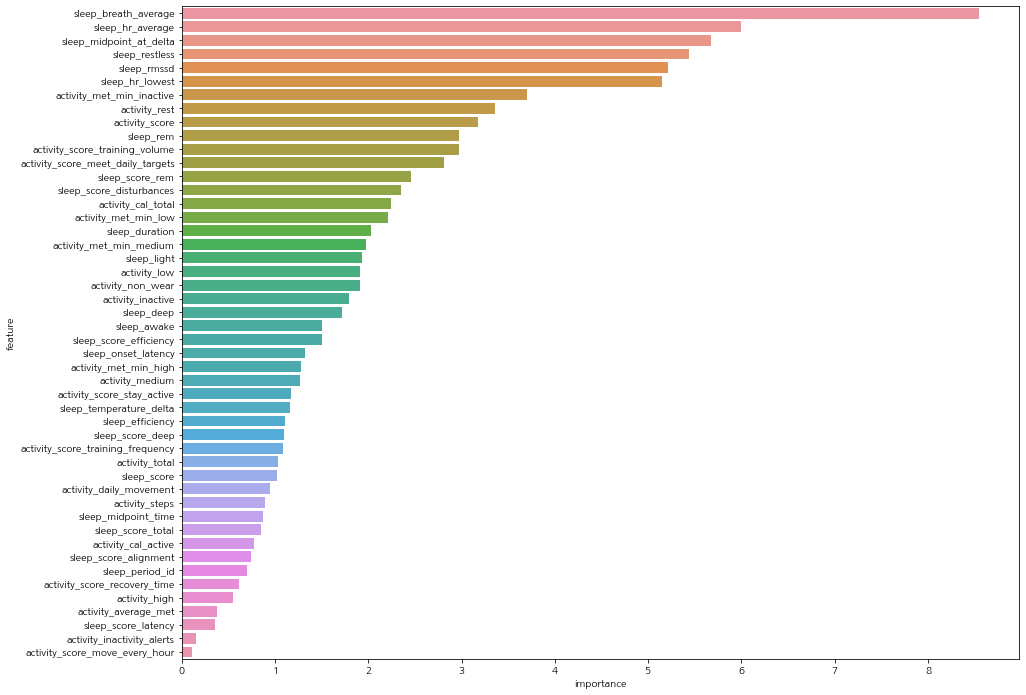

In [36]:
feature_importance_cat = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance_cat["importance"] = model_cat.feature_importances_
feature_importance_cat = feature_importance_cat.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_cat, x="importance", y="feature")

In [122]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_efficiency' 'sleep_score_deep' 'activity_score_training_frequency'
 'activity_total' 'sleep_score' 'activity_daily_movement' 'activity_steps'
 'sleep_midpoint_time' 'sleep_score_total' 'activity_cal_active'
 'sleep_score_alignment' 'sleep_period_id' 'activity_score_recovery_time'
 'activity_high' 'activity_average_met' 'sleep_score_latency'
 'activity_inactivity_alerts' 'activity_score_move_every_hour']


In [123]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [124]:
model_cat2 = CatBoostClassifier()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_cat2.fit(x_train, y_train)
    pred = model_cat2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.086674
0:	learn: 1.0498329	total: 15.3ms	remaining: 15.3s
1:	learn: 1.0088892	total: 23.8ms	remaining: 11.9s
2:	learn: 0.9717722	total: 32.4ms	remaining: 10.8s
3:	learn: 0.9435761	total: 40.3ms	remaining: 10s
4:	learn: 0.9185013	total: 48.4ms	remaining: 9.63s
5:	learn: 0.8943808	total: 57ms	remaining: 9.44s
6:	learn: 0.8737957	total: 64.7ms	remaining: 9.18s
7:	learn: 0.8548884	total: 73.6ms	remaining: 9.12s
8:	learn: 0.8369143	total: 82.9ms	remaining: 9.13s
9:	learn: 0.8227052	total: 90.2ms	remaining: 8.93s
10:	learn: 0.8074940	total: 97.8ms	remaining: 8.8s
11:	learn: 0.7943127	total: 105ms	remaining: 8.68s
12:	learn: 0.7824282	total: 114ms	remaining: 8.66s
13:	learn: 0.7696675	total: 121ms	remaining: 8.55s
14:	learn: 0.7597801	total: 129ms	remaining: 8.46s
15:	learn: 0.7496119	total: 137ms	remaining: 8.39s
16:	learn: 0.7400412	total: 145ms	remaining: 8.39s
17:	learn: 0.7308401	total: 153ms	remaining: 8.32s
18:	learn: 0.7199631	total: 161ms	remaining: 8.29s
19:	l

173:	learn: 0.3302959	total: 1.49s	remaining: 7.08s
174:	learn: 0.3293408	total: 1.5s	remaining: 7.08s
175:	learn: 0.3284161	total: 1.51s	remaining: 7.07s
176:	learn: 0.3273686	total: 1.52s	remaining: 7.06s
177:	learn: 0.3265857	total: 1.53s	remaining: 7.05s
178:	learn: 0.3254939	total: 1.53s	remaining: 7.04s
179:	learn: 0.3249734	total: 1.54s	remaining: 7.03s
180:	learn: 0.3236874	total: 1.55s	remaining: 7.02s
181:	learn: 0.3225351	total: 1.56s	remaining: 7.02s
182:	learn: 0.3216861	total: 1.57s	remaining: 7.02s
183:	learn: 0.3207773	total: 1.58s	remaining: 7.01s
184:	learn: 0.3202189	total: 1.59s	remaining: 7s
185:	learn: 0.3188505	total: 1.59s	remaining: 6.98s
186:	learn: 0.3183546	total: 1.6s	remaining: 6.97s
187:	learn: 0.3170339	total: 1.61s	remaining: 6.96s
188:	learn: 0.3162328	total: 1.62s	remaining: 6.96s
189:	learn: 0.3152759	total: 1.63s	remaining: 6.95s
190:	learn: 0.3141027	total: 1.64s	remaining: 6.94s
191:	learn: 0.3130450	total: 1.65s	remaining: 6.93s
192:	learn: 0.311

341:	learn: 0.2182908	total: 3.07s	remaining: 5.9s
342:	learn: 0.2178500	total: 3.08s	remaining: 5.89s
343:	learn: 0.2174858	total: 3.08s	remaining: 5.88s
344:	learn: 0.2172491	total: 3.09s	remaining: 5.87s
345:	learn: 0.2169083	total: 3.1s	remaining: 5.86s
346:	learn: 0.2162301	total: 3.11s	remaining: 5.85s
347:	learn: 0.2158727	total: 3.12s	remaining: 5.84s
348:	learn: 0.2151826	total: 3.12s	remaining: 5.83s
349:	learn: 0.2147257	total: 3.13s	remaining: 5.82s
350:	learn: 0.2142338	total: 3.14s	remaining: 5.8s
351:	learn: 0.2139242	total: 3.15s	remaining: 5.79s
352:	learn: 0.2135356	total: 3.15s	remaining: 5.78s
353:	learn: 0.2132449	total: 3.16s	remaining: 5.77s
354:	learn: 0.2127373	total: 3.17s	remaining: 5.76s
355:	learn: 0.2123495	total: 3.18s	remaining: 5.75s
356:	learn: 0.2117527	total: 3.19s	remaining: 5.74s
357:	learn: 0.2113671	total: 3.19s	remaining: 5.73s
358:	learn: 0.2109261	total: 3.2s	remaining: 5.71s
359:	learn: 0.2104453	total: 3.21s	remaining: 5.71s
360:	learn: 0.21

501:	learn: 0.1600767	total: 4.42s	remaining: 4.39s
502:	learn: 0.1597544	total: 4.43s	remaining: 4.38s
503:	learn: 0.1594478	total: 4.45s	remaining: 4.38s
504:	learn: 0.1591031	total: 4.46s	remaining: 4.37s
505:	learn: 0.1589689	total: 4.47s	remaining: 4.36s
506:	learn: 0.1586749	total: 4.48s	remaining: 4.36s
507:	learn: 0.1585635	total: 4.49s	remaining: 4.34s
508:	learn: 0.1583476	total: 4.5s	remaining: 4.34s
509:	learn: 0.1581750	total: 4.5s	remaining: 4.33s
510:	learn: 0.1577956	total: 4.51s	remaining: 4.32s
511:	learn: 0.1575942	total: 4.52s	remaining: 4.31s
512:	learn: 0.1573680	total: 4.53s	remaining: 4.3s
513:	learn: 0.1572173	total: 4.54s	remaining: 4.29s
514:	learn: 0.1569636	total: 4.54s	remaining: 4.28s
515:	learn: 0.1568753	total: 4.55s	remaining: 4.27s
516:	learn: 0.1565748	total: 4.56s	remaining: 4.26s
517:	learn: 0.1563755	total: 4.57s	remaining: 4.25s
518:	learn: 0.1562018	total: 4.58s	remaining: 4.24s
519:	learn: 0.1560412	total: 4.59s	remaining: 4.23s
520:	learn: 0.1

673:	learn: 0.1213330	total: 5.96s	remaining: 2.88s
674:	learn: 0.1209817	total: 5.97s	remaining: 2.87s
675:	learn: 0.1207143	total: 5.98s	remaining: 2.87s
676:	learn: 0.1205696	total: 5.99s	remaining: 2.86s
677:	learn: 0.1204016	total: 6s	remaining: 2.85s
678:	learn: 0.1202815	total: 6s	remaining: 2.84s
679:	learn: 0.1200897	total: 6.01s	remaining: 2.83s
680:	learn: 0.1199796	total: 6.02s	remaining: 2.82s
681:	learn: 0.1197738	total: 6.03s	remaining: 2.81s
682:	learn: 0.1196268	total: 6.04s	remaining: 2.8s
683:	learn: 0.1194996	total: 6.05s	remaining: 2.79s
684:	learn: 0.1192526	total: 6.06s	remaining: 2.79s
685:	learn: 0.1190755	total: 6.07s	remaining: 2.78s
686:	learn: 0.1189131	total: 6.08s	remaining: 2.77s
687:	learn: 0.1188664	total: 6.08s	remaining: 2.76s
688:	learn: 0.1186538	total: 6.09s	remaining: 2.75s
689:	learn: 0.1184899	total: 6.1s	remaining: 2.74s
690:	learn: 0.1183512	total: 6.11s	remaining: 2.73s
691:	learn: 0.1181337	total: 6.12s	remaining: 2.72s
692:	learn: 0.117961

846:	learn: 0.0937600	total: 7.67s	remaining: 1.39s
847:	learn: 0.0935813	total: 7.68s	remaining: 1.38s
848:	learn: 0.0934510	total: 7.69s	remaining: 1.37s
849:	learn: 0.0934028	total: 7.7s	remaining: 1.36s
850:	learn: 0.0932649	total: 7.71s	remaining: 1.35s
851:	learn: 0.0931636	total: 7.72s	remaining: 1.34s
852:	learn: 0.0931115	total: 7.73s	remaining: 1.33s
853:	learn: 0.0929940	total: 7.74s	remaining: 1.32s
854:	learn: 0.0928125	total: 7.75s	remaining: 1.31s
855:	learn: 0.0926801	total: 7.76s	remaining: 1.3s
856:	learn: 0.0925679	total: 7.77s	remaining: 1.29s
857:	learn: 0.0924180	total: 7.77s	remaining: 1.29s
858:	learn: 0.0922608	total: 7.78s	remaining: 1.28s
859:	learn: 0.0921340	total: 7.79s	remaining: 1.27s
860:	learn: 0.0920387	total: 7.8s	remaining: 1.26s
861:	learn: 0.0919193	total: 7.81s	remaining: 1.25s
862:	learn: 0.0917909	total: 7.82s	remaining: 1.24s
863:	learn: 0.0916509	total: 7.82s	remaining: 1.23s
864:	learn: 0.0915463	total: 7.83s	remaining: 1.22s
865:	learn: 0.0

11:	learn: 0.8169289	total: 135ms	remaining: 11.1s
12:	learn: 0.8008109	total: 143ms	remaining: 10.9s
13:	learn: 0.7872770	total: 151ms	remaining: 10.7s
14:	learn: 0.7774843	total: 159ms	remaining: 10.4s
15:	learn: 0.7620866	total: 167ms	remaining: 10.3s
16:	learn: 0.7529245	total: 175ms	remaining: 10.1s
17:	learn: 0.7434876	total: 183ms	remaining: 9.97s
18:	learn: 0.7375629	total: 191ms	remaining: 9.86s
19:	learn: 0.7293779	total: 198ms	remaining: 9.72s
20:	learn: 0.7215458	total: 206ms	remaining: 9.61s
21:	learn: 0.7144178	total: 214ms	remaining: 9.5s
22:	learn: 0.7057386	total: 222ms	remaining: 9.41s
23:	learn: 0.7009541	total: 229ms	remaining: 9.33s
24:	learn: 0.6942284	total: 238ms	remaining: 9.27s
25:	learn: 0.6872868	total: 246ms	remaining: 9.21s
26:	learn: 0.6795137	total: 254ms	remaining: 9.14s
27:	learn: 0.6741032	total: 262ms	remaining: 9.09s
28:	learn: 0.6676126	total: 270ms	remaining: 9.04s
29:	learn: 0.6615820	total: 277ms	remaining: 8.97s
30:	learn: 0.6555115	total: 285m

191:	learn: 0.3342219	total: 1.63s	remaining: 6.84s
192:	learn: 0.3334352	total: 1.63s	remaining: 6.83s
193:	learn: 0.3328205	total: 1.64s	remaining: 6.82s
194:	learn: 0.3316922	total: 1.65s	remaining: 6.81s
195:	learn: 0.3298525	total: 1.66s	remaining: 6.8s
196:	learn: 0.3291427	total: 1.67s	remaining: 6.79s
197:	learn: 0.3285347	total: 1.68s	remaining: 6.79s
198:	learn: 0.3271553	total: 1.68s	remaining: 6.78s
199:	learn: 0.3261870	total: 1.69s	remaining: 6.76s
200:	learn: 0.3250988	total: 1.7s	remaining: 6.75s
201:	learn: 0.3244716	total: 1.71s	remaining: 6.74s
202:	learn: 0.3233887	total: 1.71s	remaining: 6.73s
203:	learn: 0.3225838	total: 1.72s	remaining: 6.72s
204:	learn: 0.3216000	total: 1.73s	remaining: 6.71s
205:	learn: 0.3209483	total: 1.74s	remaining: 6.7s
206:	learn: 0.3198512	total: 1.75s	remaining: 6.7s
207:	learn: 0.3192565	total: 1.76s	remaining: 6.69s
208:	learn: 0.3185476	total: 1.76s	remaining: 6.68s
209:	learn: 0.3181514	total: 1.77s	remaining: 6.67s
210:	learn: 0.31

354:	learn: 0.2255551	total: 2.96s	remaining: 5.38s
355:	learn: 0.2251572	total: 2.97s	remaining: 5.38s
356:	learn: 0.2246493	total: 2.99s	remaining: 5.38s
357:	learn: 0.2240497	total: 3s	remaining: 5.38s
358:	learn: 0.2238274	total: 3.01s	remaining: 5.37s
359:	learn: 0.2231671	total: 3.02s	remaining: 5.37s
360:	learn: 0.2229083	total: 3.03s	remaining: 5.36s
361:	learn: 0.2224645	total: 3.04s	remaining: 5.36s
362:	learn: 0.2220213	total: 3.05s	remaining: 5.35s
363:	learn: 0.2218198	total: 3.06s	remaining: 5.34s
364:	learn: 0.2214269	total: 3.07s	remaining: 5.34s
365:	learn: 0.2210976	total: 3.07s	remaining: 5.33s
366:	learn: 0.2208571	total: 3.08s	remaining: 5.32s
367:	learn: 0.2203624	total: 3.09s	remaining: 5.31s
368:	learn: 0.2200993	total: 3.1s	remaining: 5.3s
369:	learn: 0.2197665	total: 3.1s	remaining: 5.29s
370:	learn: 0.2192698	total: 3.11s	remaining: 5.28s
371:	learn: 0.2187809	total: 3.12s	remaining: 5.27s
372:	learn: 0.2184017	total: 3.13s	remaining: 5.26s
373:	learn: 0.2178

513:	learn: 0.1689816	total: 4.28s	remaining: 4.05s
514:	learn: 0.1687887	total: 4.29s	remaining: 4.04s
515:	learn: 0.1682147	total: 4.3s	remaining: 4.03s
516:	learn: 0.1680833	total: 4.31s	remaining: 4.02s
517:	learn: 0.1678075	total: 4.32s	remaining: 4.01s
518:	learn: 0.1676511	total: 4.32s	remaining: 4.01s
519:	learn: 0.1674322	total: 4.33s	remaining: 4s
520:	learn: 0.1672977	total: 4.34s	remaining: 3.99s
521:	learn: 0.1669894	total: 4.35s	remaining: 3.98s
522:	learn: 0.1668206	total: 4.36s	remaining: 3.97s
523:	learn: 0.1666542	total: 4.37s	remaining: 3.96s
524:	learn: 0.1661520	total: 4.37s	remaining: 3.96s
525:	learn: 0.1657385	total: 4.38s	remaining: 3.95s
526:	learn: 0.1654462	total: 4.39s	remaining: 3.94s
527:	learn: 0.1649571	total: 4.4s	remaining: 3.93s
528:	learn: 0.1646403	total: 4.4s	remaining: 3.92s
529:	learn: 0.1643050	total: 4.41s	remaining: 3.91s
530:	learn: 0.1640743	total: 4.42s	remaining: 3.9s
531:	learn: 0.1637266	total: 4.43s	remaining: 3.9s
532:	learn: 0.163640

672:	learn: 0.1320994	total: 5.58s	remaining: 2.71s
673:	learn: 0.1318999	total: 5.59s	remaining: 2.7s
674:	learn: 0.1316881	total: 5.6s	remaining: 2.7s
675:	learn: 0.1315042	total: 5.61s	remaining: 2.69s
676:	learn: 0.1313424	total: 5.62s	remaining: 2.68s
677:	learn: 0.1309932	total: 5.62s	remaining: 2.67s
678:	learn: 0.1306674	total: 5.63s	remaining: 2.66s
679:	learn: 0.1303578	total: 5.64s	remaining: 2.65s
680:	learn: 0.1302463	total: 5.65s	remaining: 2.65s
681:	learn: 0.1299631	total: 5.66s	remaining: 2.64s
682:	learn: 0.1298270	total: 5.66s	remaining: 2.63s
683:	learn: 0.1296064	total: 5.67s	remaining: 2.62s
684:	learn: 0.1294745	total: 5.68s	remaining: 2.61s
685:	learn: 0.1292313	total: 5.69s	remaining: 2.6s
686:	learn: 0.1290571	total: 5.69s	remaining: 2.59s
687:	learn: 0.1288585	total: 5.7s	remaining: 2.58s
688:	learn: 0.1286822	total: 5.71s	remaining: 2.58s
689:	learn: 0.1285395	total: 5.72s	remaining: 2.57s
690:	learn: 0.1284185	total: 5.73s	remaining: 2.56s
691:	learn: 0.128

843:	learn: 0.1041072	total: 7.08s	remaining: 1.31s
844:	learn: 0.1039883	total: 7.08s	remaining: 1.3s
845:	learn: 0.1037494	total: 7.09s	remaining: 1.29s
846:	learn: 0.1036289	total: 7.1s	remaining: 1.28s
847:	learn: 0.1035312	total: 7.11s	remaining: 1.27s
848:	learn: 0.1033878	total: 7.12s	remaining: 1.26s
849:	learn: 0.1032472	total: 7.13s	remaining: 1.26s
850:	learn: 0.1031469	total: 7.13s	remaining: 1.25s
851:	learn: 0.1029517	total: 7.14s	remaining: 1.24s
852:	learn: 0.1027126	total: 7.15s	remaining: 1.23s
853:	learn: 0.1026126	total: 7.16s	remaining: 1.22s
854:	learn: 0.1024668	total: 7.17s	remaining: 1.22s
855:	learn: 0.1022668	total: 7.18s	remaining: 1.21s
856:	learn: 0.1021693	total: 7.18s	remaining: 1.2s
857:	learn: 0.1020931	total: 7.19s	remaining: 1.19s
858:	learn: 0.1020126	total: 7.2s	remaining: 1.18s
859:	learn: 0.1018411	total: 7.21s	remaining: 1.17s
860:	learn: 0.1017224	total: 7.22s	remaining: 1.16s
861:	learn: 0.1016035	total: 7.22s	remaining: 1.16s
862:	learn: 0.10

7:	learn: 0.8420377	total: 115ms	remaining: 14.3s
8:	learn: 0.8231799	total: 123ms	remaining: 13.5s
9:	learn: 0.8083109	total: 131ms	remaining: 12.9s
10:	learn: 0.7932094	total: 138ms	remaining: 12.4s
11:	learn: 0.7797280	total: 146ms	remaining: 12s
12:	learn: 0.7642887	total: 154ms	remaining: 11.7s
13:	learn: 0.7525852	total: 162ms	remaining: 11.4s
14:	learn: 0.7430695	total: 169ms	remaining: 11.1s
15:	learn: 0.7294683	total: 177ms	remaining: 10.9s
16:	learn: 0.7202805	total: 185ms	remaining: 10.7s
17:	learn: 0.7113098	total: 192ms	remaining: 10.5s
18:	learn: 0.7027529	total: 200ms	remaining: 10.3s
19:	learn: 0.6937582	total: 208ms	remaining: 10.2s
20:	learn: 0.6866778	total: 215ms	remaining: 10s
21:	learn: 0.6793481	total: 223ms	remaining: 9.92s
22:	learn: 0.6729275	total: 231ms	remaining: 9.82s
23:	learn: 0.6666986	total: 240ms	remaining: 9.76s
24:	learn: 0.6601195	total: 248ms	remaining: 9.66s
25:	learn: 0.6546600	total: 255ms	remaining: 9.55s
26:	learn: 0.6495797	total: 263ms	rema

172:	learn: 0.3176155	total: 1.42s	remaining: 6.78s
173:	learn: 0.3170092	total: 1.43s	remaining: 6.77s
174:	learn: 0.3159607	total: 1.43s	remaining: 6.76s
175:	learn: 0.3149749	total: 1.44s	remaining: 6.75s
176:	learn: 0.3141377	total: 1.45s	remaining: 6.74s
177:	learn: 0.3130267	total: 1.46s	remaining: 6.73s
178:	learn: 0.3122782	total: 1.47s	remaining: 6.72s
179:	learn: 0.3105774	total: 1.47s	remaining: 6.71s
180:	learn: 0.3099924	total: 1.48s	remaining: 6.71s
181:	learn: 0.3093727	total: 1.49s	remaining: 6.69s
182:	learn: 0.3083294	total: 1.5s	remaining: 6.68s
183:	learn: 0.3075078	total: 1.5s	remaining: 6.67s
184:	learn: 0.3064987	total: 1.51s	remaining: 6.67s
185:	learn: 0.3052163	total: 1.52s	remaining: 6.66s
186:	learn: 0.3042913	total: 1.53s	remaining: 6.64s
187:	learn: 0.3032695	total: 1.54s	remaining: 6.64s
188:	learn: 0.3026864	total: 1.54s	remaining: 6.63s
189:	learn: 0.3015451	total: 1.55s	remaining: 6.62s
190:	learn: 0.3005409	total: 1.56s	remaining: 6.61s
191:	learn: 0.

339:	learn: 0.2101535	total: 2.75s	remaining: 5.33s
340:	learn: 0.2095207	total: 2.75s	remaining: 5.32s
341:	learn: 0.2091956	total: 2.76s	remaining: 5.31s
342:	learn: 0.2087625	total: 2.77s	remaining: 5.3s
343:	learn: 0.2081172	total: 2.78s	remaining: 5.3s
344:	learn: 0.2076922	total: 2.79s	remaining: 5.29s
345:	learn: 0.2073621	total: 2.79s	remaining: 5.28s
346:	learn: 0.2069299	total: 2.8s	remaining: 5.27s
347:	learn: 0.2065665	total: 2.81s	remaining: 5.26s
348:	learn: 0.2060493	total: 2.81s	remaining: 5.25s
349:	learn: 0.2057044	total: 2.82s	remaining: 5.25s
350:	learn: 0.2050089	total: 2.83s	remaining: 5.24s
351:	learn: 0.2047768	total: 2.84s	remaining: 5.23s
352:	learn: 0.2043959	total: 2.85s	remaining: 5.22s
353:	learn: 0.2041349	total: 2.86s	remaining: 5.21s
354:	learn: 0.2035224	total: 2.87s	remaining: 5.21s
355:	learn: 0.2029593	total: 2.87s	remaining: 5.2s
356:	learn: 0.2020582	total: 2.88s	remaining: 5.19s
357:	learn: 0.2016726	total: 2.89s	remaining: 5.18s
358:	learn: 0.20

502:	learn: 0.1524787	total: 4.04s	remaining: 4s
503:	learn: 0.1523397	total: 4.05s	remaining: 3.99s
504:	learn: 0.1519734	total: 4.06s	remaining: 3.98s
505:	learn: 0.1517448	total: 4.07s	remaining: 3.97s
506:	learn: 0.1512713	total: 4.08s	remaining: 3.97s
507:	learn: 0.1508856	total: 4.09s	remaining: 3.96s
508:	learn: 0.1505176	total: 4.09s	remaining: 3.95s
509:	learn: 0.1503186	total: 4.1s	remaining: 3.94s
510:	learn: 0.1500755	total: 4.11s	remaining: 3.93s
511:	learn: 0.1496764	total: 4.12s	remaining: 3.92s
512:	learn: 0.1494598	total: 4.13s	remaining: 3.92s
513:	learn: 0.1491890	total: 4.13s	remaining: 3.91s
514:	learn: 0.1489028	total: 4.14s	remaining: 3.9s
515:	learn: 0.1485180	total: 4.15s	remaining: 3.89s
516:	learn: 0.1481649	total: 4.16s	remaining: 3.88s
517:	learn: 0.1479171	total: 4.17s	remaining: 3.88s
518:	learn: 0.1475993	total: 4.17s	remaining: 3.87s
519:	learn: 0.1474172	total: 4.18s	remaining: 3.86s
520:	learn: 0.1471839	total: 4.19s	remaining: 3.85s
521:	learn: 0.146

661:	learn: 0.1147598	total: 5.35s	remaining: 2.73s
662:	learn: 0.1144697	total: 5.36s	remaining: 2.72s
663:	learn: 0.1143498	total: 5.36s	remaining: 2.71s
664:	learn: 0.1141540	total: 5.37s	remaining: 2.71s
665:	learn: 0.1138847	total: 5.38s	remaining: 2.7s
666:	learn: 0.1137058	total: 5.39s	remaining: 2.69s
667:	learn: 0.1136067	total: 5.4s	remaining: 2.68s
668:	learn: 0.1134620	total: 5.4s	remaining: 2.67s
669:	learn: 0.1133317	total: 5.41s	remaining: 2.67s
670:	learn: 0.1131896	total: 5.42s	remaining: 2.66s
671:	learn: 0.1129982	total: 5.43s	remaining: 2.65s
672:	learn: 0.1128954	total: 5.43s	remaining: 2.64s
673:	learn: 0.1127295	total: 5.44s	remaining: 2.63s
674:	learn: 0.1125956	total: 5.45s	remaining: 2.62s
675:	learn: 0.1123916	total: 5.46s	remaining: 2.62s
676:	learn: 0.1123260	total: 5.47s	remaining: 2.61s
677:	learn: 0.1121472	total: 5.48s	remaining: 2.6s
678:	learn: 0.1118947	total: 5.48s	remaining: 2.59s
679:	learn: 0.1117755	total: 5.49s	remaining: 2.58s
680:	learn: 0.11

823:	learn: 0.0901711	total: 6.65s	remaining: 1.42s
824:	learn: 0.0900147	total: 6.66s	remaining: 1.41s
825:	learn: 0.0899041	total: 6.66s	remaining: 1.4s
826:	learn: 0.0897270	total: 6.67s	remaining: 1.4s
827:	learn: 0.0895688	total: 6.68s	remaining: 1.39s
828:	learn: 0.0894762	total: 6.69s	remaining: 1.38s
829:	learn: 0.0893457	total: 6.7s	remaining: 1.37s
830:	learn: 0.0891537	total: 6.7s	remaining: 1.36s
831:	learn: 0.0890806	total: 6.71s	remaining: 1.35s
832:	learn: 0.0888358	total: 6.72s	remaining: 1.35s
833:	learn: 0.0887374	total: 6.73s	remaining: 1.34s
834:	learn: 0.0886214	total: 6.74s	remaining: 1.33s
835:	learn: 0.0885401	total: 6.74s	remaining: 1.32s
836:	learn: 0.0884959	total: 6.75s	remaining: 1.31s
837:	learn: 0.0884157	total: 6.76s	remaining: 1.31s
838:	learn: 0.0882322	total: 6.77s	remaining: 1.3s
839:	learn: 0.0880047	total: 6.77s	remaining: 1.29s
840:	learn: 0.0878134	total: 6.78s	remaining: 1.28s
841:	learn: 0.0876483	total: 6.79s	remaining: 1.27s
842:	learn: 0.087

985:	learn: 0.0722601	total: 7.95s	remaining: 113ms
986:	learn: 0.0721576	total: 7.96s	remaining: 105ms
987:	learn: 0.0720981	total: 7.96s	remaining: 96.7ms
988:	learn: 0.0720100	total: 7.97s	remaining: 88.7ms
989:	learn: 0.0718275	total: 7.98s	remaining: 80.6ms
990:	learn: 0.0717601	total: 7.99s	remaining: 72.5ms
991:	learn: 0.0716835	total: 7.99s	remaining: 64.5ms
992:	learn: 0.0716139	total: 8s	remaining: 56.4ms
993:	learn: 0.0714992	total: 8.01s	remaining: 48.4ms
994:	learn: 0.0714384	total: 8.02s	remaining: 40.3ms
995:	learn: 0.0713493	total: 8.03s	remaining: 32.2ms
996:	learn: 0.0711895	total: 8.03s	remaining: 24.2ms
997:	learn: 0.0711444	total: 8.04s	remaining: 16.1ms
998:	learn: 0.0709724	total: 8.05s	remaining: 8.06ms
999:	learn: 0.0708611	total: 8.06s	remaining: 0us

#3 교차 검증 정확도 : 0.5335,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]
Learning rate set to 0.086675
0:	learn: 1.0525418	total: 9.85ms	remaining: 9.84s
1:	learn: 1.0118713	

152:	learn: 0.3729195	total: 1.25s	remaining: 6.91s
153:	learn: 0.3720845	total: 1.26s	remaining: 6.91s
154:	learn: 0.3710649	total: 1.26s	remaining: 6.89s
155:	learn: 0.3699837	total: 1.27s	remaining: 6.88s
156:	learn: 0.3689593	total: 1.28s	remaining: 6.88s
157:	learn: 0.3680087	total: 1.29s	remaining: 6.87s
158:	learn: 0.3662378	total: 1.3s	remaining: 6.86s
159:	learn: 0.3650300	total: 1.3s	remaining: 6.85s
160:	learn: 0.3643818	total: 1.31s	remaining: 6.83s
161:	learn: 0.3637411	total: 1.32s	remaining: 6.83s
162:	learn: 0.3626705	total: 1.33s	remaining: 6.82s
163:	learn: 0.3613149	total: 1.34s	remaining: 6.81s
164:	learn: 0.3606199	total: 1.34s	remaining: 6.8s
165:	learn: 0.3592213	total: 1.35s	remaining: 6.79s
166:	learn: 0.3582135	total: 1.36s	remaining: 6.79s
167:	learn: 0.3566071	total: 1.37s	remaining: 6.79s
168:	learn: 0.3559866	total: 1.38s	remaining: 6.78s
169:	learn: 0.3546040	total: 1.39s	remaining: 6.76s
170:	learn: 0.3534934	total: 1.39s	remaining: 6.75s
171:	learn: 0.3

312:	learn: 0.2513410	total: 2.56s	remaining: 5.61s
313:	learn: 0.2507146	total: 2.56s	remaining: 5.6s
314:	learn: 0.2504810	total: 2.57s	remaining: 5.59s
315:	learn: 0.2499133	total: 2.58s	remaining: 5.58s
316:	learn: 0.2492910	total: 2.59s	remaining: 5.57s
317:	learn: 0.2491028	total: 2.6s	remaining: 5.57s
318:	learn: 0.2485596	total: 2.6s	remaining: 5.56s
319:	learn: 0.2480139	total: 2.61s	remaining: 5.55s
320:	learn: 0.2472468	total: 2.62s	remaining: 5.54s
321:	learn: 0.2468684	total: 2.63s	remaining: 5.54s
322:	learn: 0.2464790	total: 2.64s	remaining: 5.53s
323:	learn: 0.2459659	total: 2.65s	remaining: 5.52s
324:	learn: 0.2453836	total: 2.65s	remaining: 5.51s
325:	learn: 0.2450787	total: 2.66s	remaining: 5.5s
326:	learn: 0.2445125	total: 2.67s	remaining: 5.49s
327:	learn: 0.2437395	total: 2.68s	remaining: 5.48s
328:	learn: 0.2436329	total: 2.68s	remaining: 5.47s
329:	learn: 0.2432303	total: 2.69s	remaining: 5.47s
330:	learn: 0.2429489	total: 2.7s	remaining: 5.46s
331:	learn: 0.242

473:	learn: 0.1866319	total: 3.87s	remaining: 4.29s
474:	learn: 0.1860526	total: 3.87s	remaining: 4.28s
475:	learn: 0.1857933	total: 3.88s	remaining: 4.27s
476:	learn: 0.1854465	total: 3.89s	remaining: 4.27s
477:	learn: 0.1851691	total: 3.9s	remaining: 4.26s
478:	learn: 0.1848819	total: 3.91s	remaining: 4.25s
479:	learn: 0.1844744	total: 3.92s	remaining: 4.24s
480:	learn: 0.1841329	total: 3.92s	remaining: 4.23s
481:	learn: 0.1838790	total: 3.93s	remaining: 4.23s
482:	learn: 0.1836046	total: 3.94s	remaining: 4.22s
483:	learn: 0.1831402	total: 3.95s	remaining: 4.21s
484:	learn: 0.1828055	total: 3.96s	remaining: 4.2s
485:	learn: 0.1825239	total: 3.96s	remaining: 4.19s
486:	learn: 0.1822046	total: 3.97s	remaining: 4.18s
487:	learn: 0.1818457	total: 3.98s	remaining: 4.17s
488:	learn: 0.1816620	total: 3.99s	remaining: 4.17s
489:	learn: 0.1813928	total: 4s	remaining: 4.16s
490:	learn: 0.1811115	total: 4s	remaining: 4.15s
491:	learn: 0.1808232	total: 4.01s	remaining: 4.14s
492:	learn: 0.180555

634:	learn: 0.1438574	total: 5.17s	remaining: 2.97s
635:	learn: 0.1436124	total: 5.18s	remaining: 2.96s
636:	learn: 0.1432573	total: 5.19s	remaining: 2.96s
637:	learn: 0.1429533	total: 5.19s	remaining: 2.95s
638:	learn: 0.1427425	total: 5.2s	remaining: 2.94s
639:	learn: 0.1426232	total: 5.21s	remaining: 2.93s
640:	learn: 0.1422812	total: 5.22s	remaining: 2.92s
641:	learn: 0.1421839	total: 5.22s	remaining: 2.91s
642:	learn: 0.1420664	total: 5.23s	remaining: 2.9s
643:	learn: 0.1419214	total: 5.24s	remaining: 2.9s
644:	learn: 0.1418142	total: 5.25s	remaining: 2.89s
645:	learn: 0.1414525	total: 5.26s	remaining: 2.88s
646:	learn: 0.1410959	total: 5.26s	remaining: 2.87s
647:	learn: 0.1408800	total: 5.27s	remaining: 2.86s
648:	learn: 0.1407074	total: 5.28s	remaining: 2.86s
649:	learn: 0.1404434	total: 5.29s	remaining: 2.85s
650:	learn: 0.1402482	total: 5.3s	remaining: 2.84s
651:	learn: 0.1399834	total: 5.31s	remaining: 2.83s
652:	learn: 0.1396222	total: 5.32s	remaining: 2.83s
653:	learn: 0.13

814:	learn: 0.1101818	total: 6.64s	remaining: 1.51s
815:	learn: 0.1100350	total: 6.64s	remaining: 1.5s
816:	learn: 0.1099056	total: 6.65s	remaining: 1.49s
817:	learn: 0.1097646	total: 6.66s	remaining: 1.48s
818:	learn: 0.1094038	total: 6.67s	remaining: 1.47s
819:	learn: 0.1092010	total: 6.68s	remaining: 1.47s
820:	learn: 0.1089458	total: 6.68s	remaining: 1.46s
821:	learn: 0.1088091	total: 6.69s	remaining: 1.45s
822:	learn: 0.1087181	total: 6.7s	remaining: 1.44s
823:	learn: 0.1086179	total: 6.71s	remaining: 1.43s
824:	learn: 0.1084543	total: 6.71s	remaining: 1.42s
825:	learn: 0.1083874	total: 6.72s	remaining: 1.42s
826:	learn: 0.1082562	total: 6.73s	remaining: 1.41s
827:	learn: 0.1081596	total: 6.74s	remaining: 1.4s
828:	learn: 0.1080227	total: 6.75s	remaining: 1.39s
829:	learn: 0.1078298	total: 6.76s	remaining: 1.38s
830:	learn: 0.1076838	total: 6.76s	remaining: 1.38s
831:	learn: 0.1075726	total: 6.77s	remaining: 1.37s
832:	learn: 0.1074809	total: 6.78s	remaining: 1.36s
833:	learn: 0.1

995:	learn: 0.0878469	total: 8.13s	remaining: 32.7ms
996:	learn: 0.0877595	total: 8.14s	remaining: 24.5ms
997:	learn: 0.0875742	total: 8.15s	remaining: 16.3ms
998:	learn: 0.0874141	total: 8.16s	remaining: 8.16ms
999:	learn: 0.0872013	total: 8.16s	remaining: 0us

#4 교차 검증 정확도 : 0.5389,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]
Learning rate set to 0.086675
0:	learn: 1.0535526	total: 49.7ms	remaining: 49.6s
1:	learn: 1.0115921	total: 72.9ms	remaining: 36.4s
2:	learn: 0.9747355	total: 87.5ms	remaining: 29.1s
3:	learn: 0.9447275	total: 98.3ms	remaining: 24.5s
4:	learn: 0.9168535	total: 107ms	remaining: 21.3s
5:	learn: 0.8907479	total: 116ms	remaining: 19.2s
6:	learn: 0.8679712	total: 124ms	remaining: 17.6s
7:	learn: 0.8488024	total: 132ms	remaining: 16.4s
8:	learn: 0.8284018	total: 139ms	remaining: 15.3s
9:	learn: 0.8112333	total: 149ms	remaining: 14.7s
10:	learn: 0.7946891	total: 157ms	remaining: 14.1s
11:	learn: 0.7813585	total: 165ms	remaini

159:	learn: 0.3413732	total: 1.36s	remaining: 7.17s
160:	learn: 0.3400390	total: 1.37s	remaining: 7.16s
161:	learn: 0.3391516	total: 1.38s	remaining: 7.15s
162:	learn: 0.3378851	total: 1.39s	remaining: 7.14s
163:	learn: 0.3369977	total: 1.4s	remaining: 7.12s
164:	learn: 0.3358025	total: 1.41s	remaining: 7.11s
165:	learn: 0.3352183	total: 1.41s	remaining: 7.1s
166:	learn: 0.3344880	total: 1.42s	remaining: 7.09s
167:	learn: 0.3327716	total: 1.43s	remaining: 7.08s
168:	learn: 0.3313992	total: 1.44s	remaining: 7.07s
169:	learn: 0.3305555	total: 1.44s	remaining: 7.05s
170:	learn: 0.3293055	total: 1.45s	remaining: 7.04s
171:	learn: 0.3278794	total: 1.46s	remaining: 7.03s
172:	learn: 0.3268433	total: 1.47s	remaining: 7.02s
173:	learn: 0.3257561	total: 1.48s	remaining: 7.01s
174:	learn: 0.3246858	total: 1.48s	remaining: 7s
175:	learn: 0.3231162	total: 1.49s	remaining: 6.99s
176:	learn: 0.3219869	total: 1.5s	remaining: 6.99s
177:	learn: 0.3213075	total: 1.51s	remaining: 6.98s
178:	learn: 0.3205

320:	learn: 0.2205841	total: 2.67s	remaining: 5.64s
321:	learn: 0.2200973	total: 2.67s	remaining: 5.63s
322:	learn: 0.2196293	total: 2.68s	remaining: 5.62s
323:	learn: 0.2187708	total: 2.69s	remaining: 5.62s
324:	learn: 0.2184500	total: 2.7s	remaining: 5.61s
325:	learn: 0.2178535	total: 2.71s	remaining: 5.6s
326:	learn: 0.2172361	total: 2.72s	remaining: 5.59s
327:	learn: 0.2162915	total: 2.73s	remaining: 5.58s
328:	learn: 0.2161402	total: 2.73s	remaining: 5.58s
329:	learn: 0.2154651	total: 2.74s	remaining: 5.57s
330:	learn: 0.2149841	total: 2.75s	remaining: 5.56s
331:	learn: 0.2146310	total: 2.76s	remaining: 5.55s
332:	learn: 0.2140904	total: 2.77s	remaining: 5.54s
333:	learn: 0.2135661	total: 2.77s	remaining: 5.53s
334:	learn: 0.2130423	total: 2.78s	remaining: 5.52s
335:	learn: 0.2127836	total: 2.79s	remaining: 5.52s
336:	learn: 0.2123504	total: 2.8s	remaining: 5.51s
337:	learn: 0.2116396	total: 2.81s	remaining: 5.5s
338:	learn: 0.2111704	total: 2.81s	remaining: 5.49s
339:	learn: 0.21

486:	learn: 0.1561836	total: 4.03s	remaining: 4.25s
487:	learn: 0.1556686	total: 4.04s	remaining: 4.24s
488:	learn: 0.1553824	total: 4.05s	remaining: 4.23s
489:	learn: 0.1549898	total: 4.06s	remaining: 4.22s
490:	learn: 0.1546068	total: 4.07s	remaining: 4.21s
491:	learn: 0.1540983	total: 4.07s	remaining: 4.21s
492:	learn: 0.1537591	total: 4.08s	remaining: 4.2s
493:	learn: 0.1534648	total: 4.09s	remaining: 4.19s
494:	learn: 0.1532768	total: 4.1s	remaining: 4.18s
495:	learn: 0.1530160	total: 4.11s	remaining: 4.17s
496:	learn: 0.1526954	total: 4.11s	remaining: 4.16s
497:	learn: 0.1524800	total: 4.12s	remaining: 4.16s
498:	learn: 0.1522777	total: 4.13s	remaining: 4.15s
499:	learn: 0.1518179	total: 4.14s	remaining: 4.14s
500:	learn: 0.1516421	total: 4.15s	remaining: 4.13s
501:	learn: 0.1514030	total: 4.16s	remaining: 4.12s
502:	learn: 0.1510355	total: 4.16s	remaining: 4.11s
503:	learn: 0.1507438	total: 4.17s	remaining: 4.1s
504:	learn: 0.1504587	total: 4.18s	remaining: 4.1s
505:	learn: 0.15

648:	learn: 0.1166092	total: 5.36s	remaining: 2.9s
649:	learn: 0.1163405	total: 5.37s	remaining: 2.89s
650:	learn: 0.1161648	total: 5.37s	remaining: 2.88s
651:	learn: 0.1161048	total: 5.38s	remaining: 2.87s
652:	learn: 0.1159464	total: 5.39s	remaining: 2.87s
653:	learn: 0.1157392	total: 5.4s	remaining: 2.86s
654:	learn: 0.1155215	total: 5.41s	remaining: 2.85s
655:	learn: 0.1154546	total: 5.42s	remaining: 2.84s
656:	learn: 0.1152016	total: 5.42s	remaining: 2.83s
657:	learn: 0.1150834	total: 5.43s	remaining: 2.82s
658:	learn: 0.1149173	total: 5.44s	remaining: 2.82s
659:	learn: 0.1147452	total: 5.45s	remaining: 2.81s
660:	learn: 0.1144252	total: 5.46s	remaining: 2.8s
661:	learn: 0.1143107	total: 5.47s	remaining: 2.79s
662:	learn: 0.1140560	total: 5.47s	remaining: 2.78s
663:	learn: 0.1138951	total: 5.48s	remaining: 2.77s
664:	learn: 0.1138088	total: 5.49s	remaining: 2.77s
665:	learn: 0.1136077	total: 5.5s	remaining: 2.76s
666:	learn: 0.1134922	total: 5.51s	remaining: 2.75s
667:	learn: 0.11

807:	learn: 0.0921118	total: 6.66s	remaining: 1.58s
808:	learn: 0.0920129	total: 6.67s	remaining: 1.57s
809:	learn: 0.0918603	total: 6.67s	remaining: 1.56s
810:	learn: 0.0917005	total: 6.68s	remaining: 1.56s
811:	learn: 0.0916280	total: 6.69s	remaining: 1.55s
812:	learn: 0.0914535	total: 6.7s	remaining: 1.54s
813:	learn: 0.0913171	total: 6.71s	remaining: 1.53s
814:	learn: 0.0912752	total: 6.72s	remaining: 1.52s
815:	learn: 0.0911226	total: 6.72s	remaining: 1.52s
816:	learn: 0.0909842	total: 6.73s	remaining: 1.51s
817:	learn: 0.0908319	total: 6.74s	remaining: 1.5s
818:	learn: 0.0906014	total: 6.75s	remaining: 1.49s
819:	learn: 0.0904891	total: 6.76s	remaining: 1.48s
820:	learn: 0.0903744	total: 6.76s	remaining: 1.48s
821:	learn: 0.0902383	total: 6.77s	remaining: 1.47s
822:	learn: 0.0900769	total: 6.78s	remaining: 1.46s
823:	learn: 0.0899711	total: 6.79s	remaining: 1.45s
824:	learn: 0.0897724	total: 6.8s	remaining: 1.44s
825:	learn: 0.0897290	total: 6.8s	remaining: 1.43s
826:	learn: 0.08

978:	learn: 0.0732880	total: 8.15s	remaining: 175ms
979:	learn: 0.0731962	total: 8.16s	remaining: 167ms
980:	learn: 0.0730947	total: 8.17s	remaining: 158ms
981:	learn: 0.0730125	total: 8.18s	remaining: 150ms
982:	learn: 0.0728940	total: 8.19s	remaining: 142ms
983:	learn: 0.0727893	total: 8.2s	remaining: 133ms
984:	learn: 0.0727000	total: 8.21s	remaining: 125ms
985:	learn: 0.0726153	total: 8.22s	remaining: 117ms
986:	learn: 0.0725638	total: 8.23s	remaining: 108ms
987:	learn: 0.0724989	total: 8.24s	remaining: 100ms
988:	learn: 0.0724221	total: 8.25s	remaining: 91.7ms
989:	learn: 0.0723584	total: 8.26s	remaining: 83.4ms
990:	learn: 0.0722267	total: 8.27s	remaining: 75.1ms
991:	learn: 0.0721213	total: 8.28s	remaining: 66.7ms
992:	learn: 0.0719999	total: 8.28s	remaining: 58.4ms
993:	learn: 0.0719061	total: 8.29s	remaining: 50.1ms
994:	learn: 0.0718010	total: 8.3s	remaining: 41.7ms
995:	learn: 0.0717257	total: 8.31s	remaining: 33.4ms
996:	learn: 0.0716681	total: 8.32s	remaining: 25ms
997:	le

In [125]:
pred_cat_prob = model_cat2.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1194
           1       0.89      0.83      0.86       129
           2       0.84      0.74      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.83      0.85      1866
weighted avg       0.87      0.87      0.87      1866



# 6. Interpret

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [140]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    #true_y = test_y.to_numpy()
    true_y = np.ravel(test_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

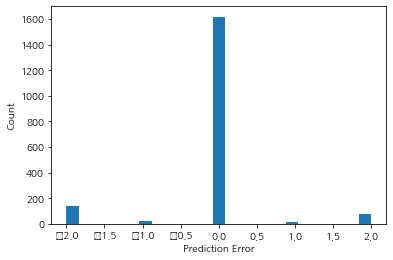

In [142]:
show_prediction_error(test_y, pred_xgb)

In [117]:
feature_list = []
feature_list = feature_list + feature_importance_rf['feature'].head(3).values.tolist()
feature_list = feature_list + feature_importance_ab['feature'].head(3).values.tolist()
feature_list = feature_list + feature_importance_xgb['feature'].head(3).values.tolist()
feature_list = feature_list + feature_importance_lgbm['feature'].head(3).values.tolist()
feature_list = feature_list + feature_importance_cat['feature'].head(3).values.tolist()

from collections import Counter

feature_cnt = Counter()
for element in feature_list :
    feature_cnt[element] += 1 
feature_cnt = dict(feature_cnt)
feature_cnt = pd.DataFrame.from_dict(feature_cnt, orient='index')
feature_cnt = feature_cnt.rename(columns={'index':'feature', 0:'count'})
feature_cnt = feature_cnt.sort_values(by=["count"], ascending=False).reset_index()

feature_cnt

,index,count
0,sleep_breath_average,3
1,sleep_hr_average,3
2,sleep_midpoint_at_delta,2
3,sleep_restless,2
4,activity_score_meet_daily_targets,2
5,activity_rest,1
6,activity_met_min_inactive,1
7,sleep_score_efficiency,1


<AxesSubplot:xlabel='count', ylabel='index'>

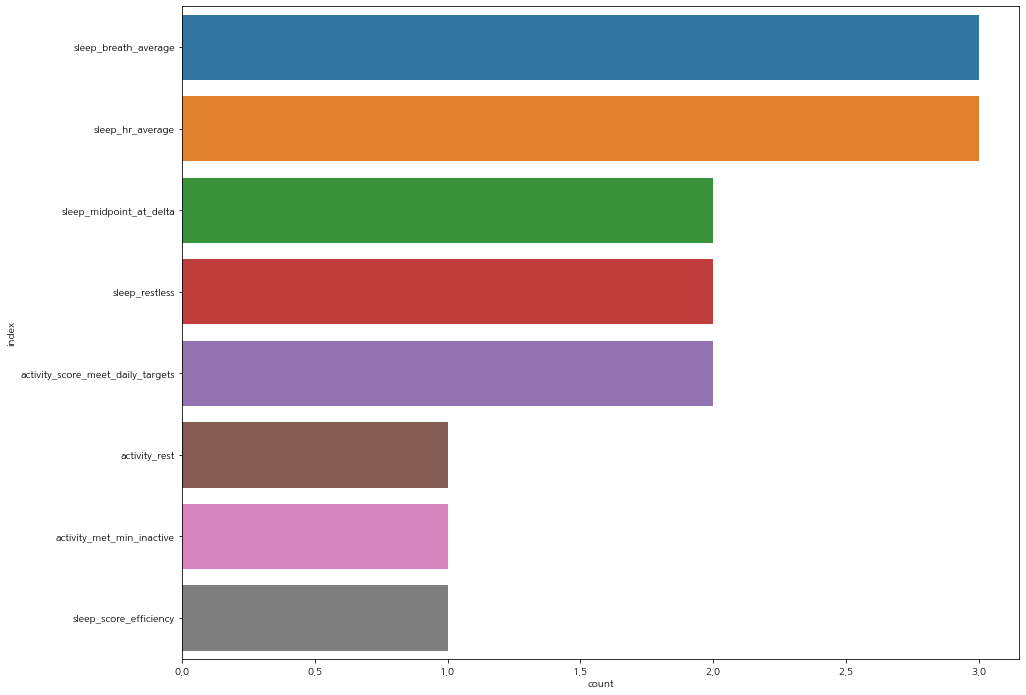

In [118]:
plt.figure(figsize = (15,12))
sns.barplot(data=feature_cnt, x="count", y="index")

C:\Users\Hyeongbin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


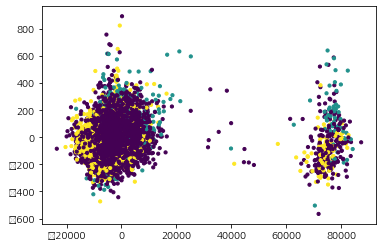

In [119]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

feature_cols = feature_cnt['index'].values.tolist()
pca_data = processed_data[feature_cols]

pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data = pd.DataFrame(pca_data)

pca_data = pd.concat([pca_data, processed_data['DIAG_NM']], axis=1)

le = LabelEncoder()
pca_data['DIAG_NM'] = le.fit_transform(list(pca_data['DIAG_NM']))

plt.scatter(pca_data[0], pca_data[1], c=pca_data["DIAG_NM"], s=10)
plt.show()

C:\Users\Hyeongbin\AppData\Local\Temp\ipykernel_10412\1926269807.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


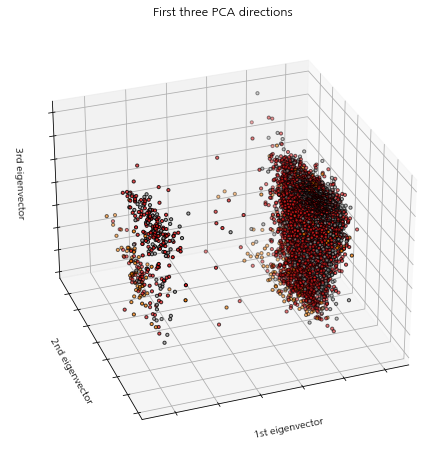

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

feature_cols = feature_cnt['index'].values.tolist()
pca_data = processed_data[feature_cols]

test_pca = PCA(n_components=3).fit_transform(pca_data)
test_pca = pd.DataFrame(test_pca) 
test_pca["target"] = pd.DataFrame(processed_data['DIAG_NM']) 
le = LabelEncoder()
test_pca['target'] = le.fit_transform(list(test_pca['target']))

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(test_pca[0], test_pca[1], test_pca[2], c=test_pca["target"],
           cmap=plt.cm.Set1, edgecolor='k', s=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# 7. Modeling - DL 

총 2개의 모델을 설계/실험하였다. 

- CNN
- Convolutional-Auto Encoder 
    - encoder9 에서 output 숫자를 수정해가면서 가장 최적의 hyper parameter를 찾아갑니다 
    - sig_data1 : 7
    - sig_data2 : 4
    - sig_data3 : 6
    - sig_data4 : 4
    - sig_data5 : 6

In [91]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from IPython.display import Image

# in order to always get the same result
tf.random.set_seed(1)
np.random.seed(1)

In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout, Flatten
from keras.models import Model
input_layer = Input(shape=(28,28,1))

# Encoder
encoder1 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(input_layer)
encoder2 = MaxPooling2D(pool_size = (2, 2), padding='same')(encoder1)
encoder3 = Conv2D(filters = 48, kernel_size = (3, 3), activation='relu', padding='same')(encoder2)
encoder4 = MaxPooling2D(pool_size = (2, 2), padding='same')(encoder3)
encoder5 = Dropout(0.5)(encoder4)

encoder6 = Flatten()(encoder5)
encoder7 = Dense(256, activation='sigmoid')(encoder6)
encoder8 = Dropout(0.5)(encoder7)
encoder9 = Dense(6, activation='softmax')(encoder8)

# Decoder
decoder1 = Dense(2352)(encoder9)
decoder2 = Reshape((7,7,48))(decoder1)
decoder3 = Conv2D(48, (3, 3), activation='relu', padding='same')(decoder2)
decoder4 = UpSampling2D((2, 2))(decoder3)
decoder5 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder4)
decoder6 = UpSampling2D((2, 2))(decoder5)

output_layer = Conv2D(1, (28,28), padding='same')(decoder6)

# Optimizer
opti = tf.keras.optimizers.Adam(learning_rate=0.01,name='Adam')

autoencoder = Model(inputs=input_layer, outputs=decoder6)

In [93]:
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 48)        13872     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 48)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2352)              0  

In [144]:
# image를 따로 관리합니다 
# original image -> data_img
# preprocessing data -> processed_img
processed_img = []

for i in range(len(filenames)):
  mypath = path + '/' + filenames[i]
  print(mypath)
  data = cv.imread(mypath, 0)
  img = cv.resize(data, None, fx=28/349, fy=28/231)
  img = img/255
  processed_img.append(img)

# image를 따로 관리합니다 
# preprocessing image -> processed_img
# input image -> input_img
np_img = np.array(processed_img)
print(type(np_img))

input_img = np_img.reshape(len(processed_img),img.shape[0],img.shape[1],1)

./Dataset/pic_dataset/sig_data5//CN_0.png
./Dataset/pic_dataset/sig_data5//CN_1.png
./Dataset/pic_dataset/sig_data5//CN_10.png
./Dataset/pic_dataset/sig_data5//CN_1000.png
./Dataset/pic_dataset/sig_data5//CN_1001.png
./Dataset/pic_dataset/sig_data5//CN_1002.png
./Dataset/pic_dataset/sig_data5//CN_1003.png
./Dataset/pic_dataset/sig_data5//CN_1004.png
./Dataset/pic_dataset/sig_data5//CN_1005.png
./Dataset/pic_dataset/sig_data5//CN_1006.png
./Dataset/pic_dataset/sig_data5//CN_1007.png
./Dataset/pic_dataset/sig_data5//CN_1008.png
./Dataset/pic_dataset/sig_data5//CN_1009.png
./Dataset/pic_dataset/sig_data5//CN_1010.png
./Dataset/pic_dataset/sig_data5//CN_1011.png
./Dataset/pic_dataset/sig_data5//CN_1012.png
./Dataset/pic_dataset/sig_data5//CN_1013.png
./Dataset/pic_dataset/sig_data5//CN_1014.png
./Dataset/pic_dataset/sig_data5//CN_1015.png
./Dataset/pic_dataset/sig_data5//CN_1016.png
./Dataset/pic_dataset/sig_data5//CN_1017.png
./Dataset/pic_dataset/sig_data5//CN_1018.png
./Dataset/pic_data

./Dataset/pic_dataset/sig_data5//CN_1414.png
./Dataset/pic_dataset/sig_data5//CN_1415.png
./Dataset/pic_dataset/sig_data5//CN_1416.png
./Dataset/pic_dataset/sig_data5//CN_1417.png
./Dataset/pic_dataset/sig_data5//CN_1418.png
./Dataset/pic_dataset/sig_data5//CN_1419.png
./Dataset/pic_dataset/sig_data5//CN_1420.png
./Dataset/pic_dataset/sig_data5//CN_1421.png
./Dataset/pic_dataset/sig_data5//CN_1422.png
./Dataset/pic_dataset/sig_data5//CN_1423.png
./Dataset/pic_dataset/sig_data5//CN_1424.png
./Dataset/pic_dataset/sig_data5//CN_1425.png
./Dataset/pic_dataset/sig_data5//CN_1426.png
./Dataset/pic_dataset/sig_data5//CN_1427.png
./Dataset/pic_dataset/sig_data5//CN_1428.png
./Dataset/pic_dataset/sig_data5//CN_1429.png
./Dataset/pic_dataset/sig_data5//CN_1430.png
./Dataset/pic_dataset/sig_data5//CN_1431.png
./Dataset/pic_dataset/sig_data5//CN_1432.png
./Dataset/pic_dataset/sig_data5//CN_1433.png
./Dataset/pic_dataset/sig_data5//CN_1434.png
./Dataset/pic_dataset/sig_data5//CN_1435.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_1856.png
./Dataset/pic_dataset/sig_data5//CN_1857.png
./Dataset/pic_dataset/sig_data5//CN_1858.png
./Dataset/pic_dataset/sig_data5//CN_1859.png
./Dataset/pic_dataset/sig_data5//CN_186.png
./Dataset/pic_dataset/sig_data5//CN_1860.png
./Dataset/pic_dataset/sig_data5//CN_1861.png
./Dataset/pic_dataset/sig_data5//CN_1862.png
./Dataset/pic_dataset/sig_data5//CN_1863.png
./Dataset/pic_dataset/sig_data5//CN_1864.png
./Dataset/pic_dataset/sig_data5//CN_1865.png
./Dataset/pic_dataset/sig_data5//CN_1866.png
./Dataset/pic_dataset/sig_data5//CN_1867.png
./Dataset/pic_dataset/sig_data5//CN_1868.png
./Dataset/pic_dataset/sig_data5//CN_1869.png
./Dataset/pic_dataset/sig_data5//CN_187.png
./Dataset/pic_dataset/sig_data5//CN_1870.png
./Dataset/pic_dataset/sig_data5//CN_1871.png
./Dataset/pic_dataset/sig_data5//CN_1872.png
./Dataset/pic_dataset/sig_data5//CN_1873.png
./Dataset/pic_dataset/sig_data5//CN_1874.png
./Dataset/pic_dataset/sig_data5//CN_1875.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_2227.png
./Dataset/pic_dataset/sig_data5//CN_2228.png
./Dataset/pic_dataset/sig_data5//CN_2229.png
./Dataset/pic_dataset/sig_data5//CN_223.png
./Dataset/pic_dataset/sig_data5//CN_2230.png
./Dataset/pic_dataset/sig_data5//CN_2231.png
./Dataset/pic_dataset/sig_data5//CN_2232.png
./Dataset/pic_dataset/sig_data5//CN_2233.png
./Dataset/pic_dataset/sig_data5//CN_2234.png
./Dataset/pic_dataset/sig_data5//CN_2235.png
./Dataset/pic_dataset/sig_data5//CN_2236.png
./Dataset/pic_dataset/sig_data5//CN_2237.png
./Dataset/pic_dataset/sig_data5//CN_2238.png
./Dataset/pic_dataset/sig_data5//CN_2239.png
./Dataset/pic_dataset/sig_data5//CN_224.png
./Dataset/pic_dataset/sig_data5//CN_2240.png
./Dataset/pic_dataset/sig_data5//CN_2241.png
./Dataset/pic_dataset/sig_data5//CN_2242.png
./Dataset/pic_dataset/sig_data5//CN_2243.png
./Dataset/pic_dataset/sig_data5//CN_2244.png
./Dataset/pic_dataset/sig_data5//CN_2245.png
./Dataset/pic_dataset/sig_data5//CN_2246.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_2453.png
./Dataset/pic_dataset/sig_data5//CN_2454.png
./Dataset/pic_dataset/sig_data5//CN_2455.png
./Dataset/pic_dataset/sig_data5//CN_2456.png
./Dataset/pic_dataset/sig_data5//CN_2457.png
./Dataset/pic_dataset/sig_data5//CN_2458.png
./Dataset/pic_dataset/sig_data5//CN_2459.png
./Dataset/pic_dataset/sig_data5//CN_2460.png
./Dataset/pic_dataset/sig_data5//CN_2461.png
./Dataset/pic_dataset/sig_data5//CN_2462.png
./Dataset/pic_dataset/sig_data5//CN_2463.png
./Dataset/pic_dataset/sig_data5//CN_2464.png
./Dataset/pic_dataset/sig_data5//CN_2465.png
./Dataset/pic_dataset/sig_data5//CN_2466.png
./Dataset/pic_dataset/sig_data5//CN_2467.png
./Dataset/pic_dataset/sig_data5//CN_2468.png
./Dataset/pic_dataset/sig_data5//CN_2469.png
./Dataset/pic_dataset/sig_data5//CN_2470.png
./Dataset/pic_dataset/sig_data5//CN_2471.png
./Dataset/pic_dataset/sig_data5//CN_2472.png
./Dataset/pic_dataset/sig_data5//CN_2473.png
./Dataset/pic_dataset/sig_data5//CN_2474.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_2673.png
./Dataset/pic_dataset/sig_data5//CN_2674.png
./Dataset/pic_dataset/sig_data5//CN_2675.png
./Dataset/pic_dataset/sig_data5//CN_2676.png
./Dataset/pic_dataset/sig_data5//CN_2677.png
./Dataset/pic_dataset/sig_data5//CN_2678.png
./Dataset/pic_dataset/sig_data5//CN_2679.png
./Dataset/pic_dataset/sig_data5//CN_268.png
./Dataset/pic_dataset/sig_data5//CN_2680.png
./Dataset/pic_dataset/sig_data5//CN_2681.png
./Dataset/pic_dataset/sig_data5//CN_2682.png
./Dataset/pic_dataset/sig_data5//CN_2683.png
./Dataset/pic_dataset/sig_data5//CN_2684.png
./Dataset/pic_dataset/sig_data5//CN_2685.png
./Dataset/pic_dataset/sig_data5//CN_2686.png
./Dataset/pic_dataset/sig_data5//CN_2687.png
./Dataset/pic_dataset/sig_data5//CN_2688.png
./Dataset/pic_dataset/sig_data5//CN_2689.png
./Dataset/pic_dataset/sig_data5//CN_269.png
./Dataset/pic_dataset/sig_data5//CN_2690.png
./Dataset/pic_dataset/sig_data5//CN_2691.png
./Dataset/pic_dataset/sig_data5//CN_2692.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_287.png
./Dataset/pic_dataset/sig_data5//CN_2870.png
./Dataset/pic_dataset/sig_data5//CN_2871.png
./Dataset/pic_dataset/sig_data5//CN_2872.png
./Dataset/pic_dataset/sig_data5//CN_2873.png
./Dataset/pic_dataset/sig_data5//CN_2874.png
./Dataset/pic_dataset/sig_data5//CN_2875.png
./Dataset/pic_dataset/sig_data5//CN_2876.png
./Dataset/pic_dataset/sig_data5//CN_2877.png
./Dataset/pic_dataset/sig_data5//CN_2878.png
./Dataset/pic_dataset/sig_data5//CN_2879.png
./Dataset/pic_dataset/sig_data5//CN_288.png
./Dataset/pic_dataset/sig_data5//CN_2880.png
./Dataset/pic_dataset/sig_data5//CN_2881.png
./Dataset/pic_dataset/sig_data5//CN_2882.png
./Dataset/pic_dataset/sig_data5//CN_2883.png
./Dataset/pic_dataset/sig_data5//CN_2884.png
./Dataset/pic_dataset/sig_data5//CN_2885.png
./Dataset/pic_dataset/sig_data5//CN_2886.png
./Dataset/pic_dataset/sig_data5//CN_2887.png
./Dataset/pic_dataset/sig_data5//CN_2888.png
./Dataset/pic_dataset/sig_data5//CN_2889.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_310.png
./Dataset/pic_dataset/sig_data5//CN_3100.png
./Dataset/pic_dataset/sig_data5//CN_3101.png
./Dataset/pic_dataset/sig_data5//CN_3102.png
./Dataset/pic_dataset/sig_data5//CN_3103.png
./Dataset/pic_dataset/sig_data5//CN_3104.png
./Dataset/pic_dataset/sig_data5//CN_3105.png
./Dataset/pic_dataset/sig_data5//CN_3106.png
./Dataset/pic_dataset/sig_data5//CN_3107.png
./Dataset/pic_dataset/sig_data5//CN_3108.png
./Dataset/pic_dataset/sig_data5//CN_3109.png
./Dataset/pic_dataset/sig_data5//CN_311.png
./Dataset/pic_dataset/sig_data5//CN_3110.png
./Dataset/pic_dataset/sig_data5//CN_3111.png
./Dataset/pic_dataset/sig_data5//CN_3112.png
./Dataset/pic_dataset/sig_data5//CN_3113.png
./Dataset/pic_dataset/sig_data5//CN_3114.png
./Dataset/pic_dataset/sig_data5//CN_3115.png
./Dataset/pic_dataset/sig_data5//CN_3116.png
./Dataset/pic_dataset/sig_data5//CN_3117.png
./Dataset/pic_dataset/sig_data5//CN_3118.png
./Dataset/pic_dataset/sig_data5//CN_3119.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_3428.png
./Dataset/pic_dataset/sig_data5//CN_3429.png
./Dataset/pic_dataset/sig_data5//CN_3430.png
./Dataset/pic_dataset/sig_data5//CN_3431.png
./Dataset/pic_dataset/sig_data5//CN_3432.png
./Dataset/pic_dataset/sig_data5//CN_3433.png
./Dataset/pic_dataset/sig_data5//CN_3434.png
./Dataset/pic_dataset/sig_data5//CN_3435.png
./Dataset/pic_dataset/sig_data5//CN_3436.png
./Dataset/pic_dataset/sig_data5//CN_3437.png
./Dataset/pic_dataset/sig_data5//CN_3438.png
./Dataset/pic_dataset/sig_data5//CN_3439.png
./Dataset/pic_dataset/sig_data5//CN_3440.png
./Dataset/pic_dataset/sig_data5//CN_3441.png
./Dataset/pic_dataset/sig_data5//CN_3442.png
./Dataset/pic_dataset/sig_data5//CN_3443.png
./Dataset/pic_dataset/sig_data5//CN_3444.png
./Dataset/pic_dataset/sig_data5//CN_3445.png
./Dataset/pic_dataset/sig_data5//CN_3446.png
./Dataset/pic_dataset/sig_data5//CN_3447.png
./Dataset/pic_dataset/sig_data5//CN_3448.png
./Dataset/pic_dataset/sig_data5//CN_3449.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_3712.png
./Dataset/pic_dataset/sig_data5//CN_3713.png
./Dataset/pic_dataset/sig_data5//CN_3714.png
./Dataset/pic_dataset/sig_data5//CN_3715.png
./Dataset/pic_dataset/sig_data5//CN_3716.png
./Dataset/pic_dataset/sig_data5//CN_3717.png
./Dataset/pic_dataset/sig_data5//CN_3718.png
./Dataset/pic_dataset/sig_data5//CN_3719.png
./Dataset/pic_dataset/sig_data5//CN_3720.png
./Dataset/pic_dataset/sig_data5//CN_3721.png
./Dataset/pic_dataset/sig_data5//CN_3722.png
./Dataset/pic_dataset/sig_data5//CN_3723.png
./Dataset/pic_dataset/sig_data5//CN_3724.png
./Dataset/pic_dataset/sig_data5//CN_3725.png
./Dataset/pic_dataset/sig_data5//CN_3726.png
./Dataset/pic_dataset/sig_data5//CN_3727.png
./Dataset/pic_dataset/sig_data5//CN_3728.png
./Dataset/pic_dataset/sig_data5//CN_3729.png
./Dataset/pic_dataset/sig_data5//CN_3730.png
./Dataset/pic_dataset/sig_data5//CN_3731.png
./Dataset/pic_dataset/sig_data5//CN_3732.png
./Dataset/pic_dataset/sig_data5//CN_3733.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_410.png
./Dataset/pic_dataset/sig_data5//CN_411.png
./Dataset/pic_dataset/sig_data5//CN_4115.png
./Dataset/pic_dataset/sig_data5//CN_4116.png
./Dataset/pic_dataset/sig_data5//CN_4117.png
./Dataset/pic_dataset/sig_data5//CN_4118.png
./Dataset/pic_dataset/sig_data5//CN_4119.png
./Dataset/pic_dataset/sig_data5//CN_412.png
./Dataset/pic_dataset/sig_data5//CN_4120.png
./Dataset/pic_dataset/sig_data5//CN_4121.png
./Dataset/pic_dataset/sig_data5//CN_4122.png
./Dataset/pic_dataset/sig_data5//CN_4123.png
./Dataset/pic_dataset/sig_data5//CN_4124.png
./Dataset/pic_dataset/sig_data5//CN_4125.png
./Dataset/pic_dataset/sig_data5//CN_4126.png
./Dataset/pic_dataset/sig_data5//CN_4127.png
./Dataset/pic_dataset/sig_data5//CN_4128.png
./Dataset/pic_dataset/sig_data5//CN_4129.png
./Dataset/pic_dataset/sig_data5//CN_413.png
./Dataset/pic_dataset/sig_data5//CN_4130.png
./Dataset/pic_dataset/sig_data5//CN_4131.png
./Dataset/pic_dataset/sig_data5//CN_4132.png
./Dataset/pic_

./Dataset/pic_dataset/sig_data5//CN_4357.png
./Dataset/pic_dataset/sig_data5//CN_4358.png
./Dataset/pic_dataset/sig_data5//CN_4359.png
./Dataset/pic_dataset/sig_data5//CN_436.png
./Dataset/pic_dataset/sig_data5//CN_4360.png
./Dataset/pic_dataset/sig_data5//CN_4361.png
./Dataset/pic_dataset/sig_data5//CN_4362.png
./Dataset/pic_dataset/sig_data5//CN_4363.png
./Dataset/pic_dataset/sig_data5//CN_4364.png
./Dataset/pic_dataset/sig_data5//CN_4365.png
./Dataset/pic_dataset/sig_data5//CN_4366.png
./Dataset/pic_dataset/sig_data5//CN_4367.png
./Dataset/pic_dataset/sig_data5//CN_4368.png
./Dataset/pic_dataset/sig_data5//CN_4369.png
./Dataset/pic_dataset/sig_data5//CN_437.png
./Dataset/pic_dataset/sig_data5//CN_4370.png
./Dataset/pic_dataset/sig_data5//CN_438.png
./Dataset/pic_dataset/sig_data5//CN_439.png
./Dataset/pic_dataset/sig_data5//CN_440.png
./Dataset/pic_dataset/sig_data5//CN_441.png
./Dataset/pic_dataset/sig_data5//CN_4412.png
./Dataset/pic_dataset/sig_data5//CN_4413.png
./Dataset/pic_da

./Dataset/pic_dataset/sig_data5//CN_4605.png
./Dataset/pic_dataset/sig_data5//CN_4606.png
./Dataset/pic_dataset/sig_data5//CN_4607.png
./Dataset/pic_dataset/sig_data5//CN_4608.png
./Dataset/pic_dataset/sig_data5//CN_4609.png
./Dataset/pic_dataset/sig_data5//CN_4610.png
./Dataset/pic_dataset/sig_data5//CN_4611.png
./Dataset/pic_dataset/sig_data5//CN_4612.png
./Dataset/pic_dataset/sig_data5//CN_4613.png
./Dataset/pic_dataset/sig_data5//CN_4614.png
./Dataset/pic_dataset/sig_data5//CN_4615.png
./Dataset/pic_dataset/sig_data5//CN_4616.png
./Dataset/pic_dataset/sig_data5//CN_4617.png
./Dataset/pic_dataset/sig_data5//CN_4618.png
./Dataset/pic_dataset/sig_data5//CN_4619.png
./Dataset/pic_dataset/sig_data5//CN_4620.png
./Dataset/pic_dataset/sig_data5//CN_4621.png
./Dataset/pic_dataset/sig_data5//CN_4622.png
./Dataset/pic_dataset/sig_data5//CN_4623.png
./Dataset/pic_dataset/sig_data5//CN_4624.png
./Dataset/pic_dataset/sig_data5//CN_4625.png
./Dataset/pic_dataset/sig_data5//CN_4626.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_5049.png
./Dataset/pic_dataset/sig_data5//CN_5050.png
./Dataset/pic_dataset/sig_data5//CN_5051.png
./Dataset/pic_dataset/sig_data5//CN_5052.png
./Dataset/pic_dataset/sig_data5//CN_5053.png
./Dataset/pic_dataset/sig_data5//CN_5054.png
./Dataset/pic_dataset/sig_data5//CN_5055.png
./Dataset/pic_dataset/sig_data5//CN_5056.png
./Dataset/pic_dataset/sig_data5//CN_5057.png
./Dataset/pic_dataset/sig_data5//CN_5058.png
./Dataset/pic_dataset/sig_data5//CN_5059.png
./Dataset/pic_dataset/sig_data5//CN_5060.png
./Dataset/pic_dataset/sig_data5//CN_5061.png
./Dataset/pic_dataset/sig_data5//CN_5062.png
./Dataset/pic_dataset/sig_data5//CN_5063.png
./Dataset/pic_dataset/sig_data5//CN_5064.png
./Dataset/pic_dataset/sig_data5//CN_5065.png
./Dataset/pic_dataset/sig_data5//CN_5066.png
./Dataset/pic_dataset/sig_data5//CN_5067.png
./Dataset/pic_dataset/sig_data5//CN_5068.png
./Dataset/pic_dataset/sig_data5//CN_5069.png
./Dataset/pic_dataset/sig_data5//CN_5070.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_5338.png
./Dataset/pic_dataset/sig_data5//CN_5339.png
./Dataset/pic_dataset/sig_data5//CN_5340.png
./Dataset/pic_dataset/sig_data5//CN_5341.png
./Dataset/pic_dataset/sig_data5//CN_5342.png
./Dataset/pic_dataset/sig_data5//CN_5343.png
./Dataset/pic_dataset/sig_data5//CN_5344.png
./Dataset/pic_dataset/sig_data5//CN_5345.png
./Dataset/pic_dataset/sig_data5//CN_541.png
./Dataset/pic_dataset/sig_data5//CN_542.png
./Dataset/pic_dataset/sig_data5//CN_543.png
./Dataset/pic_dataset/sig_data5//CN_5431.png
./Dataset/pic_dataset/sig_data5//CN_5432.png
./Dataset/pic_dataset/sig_data5//CN_5433.png
./Dataset/pic_dataset/sig_data5//CN_5434.png
./Dataset/pic_dataset/sig_data5//CN_5435.png
./Dataset/pic_dataset/sig_data5//CN_5436.png
./Dataset/pic_dataset/sig_data5//CN_5437.png
./Dataset/pic_dataset/sig_data5//CN_5438.png
./Dataset/pic_dataset/sig_data5//CN_5439.png
./Dataset/pic_dataset/sig_data5//CN_544.png
./Dataset/pic_dataset/sig_data5//CN_5440.png
./Dataset/pic_

./Dataset/pic_dataset/sig_data5//CN_5678.png
./Dataset/pic_dataset/sig_data5//CN_5679.png
./Dataset/pic_dataset/sig_data5//CN_568.png
./Dataset/pic_dataset/sig_data5//CN_5680.png
./Dataset/pic_dataset/sig_data5//CN_5681.png
./Dataset/pic_dataset/sig_data5//CN_5682.png
./Dataset/pic_dataset/sig_data5//CN_5683.png
./Dataset/pic_dataset/sig_data5//CN_5684.png
./Dataset/pic_dataset/sig_data5//CN_5685.png
./Dataset/pic_dataset/sig_data5//CN_5686.png
./Dataset/pic_dataset/sig_data5//CN_5687.png
./Dataset/pic_dataset/sig_data5//CN_5688.png
./Dataset/pic_dataset/sig_data5//CN_5689.png
./Dataset/pic_dataset/sig_data5//CN_569.png
./Dataset/pic_dataset/sig_data5//CN_5690.png
./Dataset/pic_dataset/sig_data5//CN_5691.png
./Dataset/pic_dataset/sig_data5//CN_5692.png
./Dataset/pic_dataset/sig_data5//CN_5693.png
./Dataset/pic_dataset/sig_data5//CN_5694.png
./Dataset/pic_dataset/sig_data5//CN_5695.png
./Dataset/pic_dataset/sig_data5//CN_5696.png
./Dataset/pic_dataset/sig_data5//CN_5697.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_5961.png
./Dataset/pic_dataset/sig_data5//CN_5962.png
./Dataset/pic_dataset/sig_data5//CN_5963.png
./Dataset/pic_dataset/sig_data5//CN_5964.png
./Dataset/pic_dataset/sig_data5//CN_5965.png
./Dataset/pic_dataset/sig_data5//CN_5966.png
./Dataset/pic_dataset/sig_data5//CN_5967.png
./Dataset/pic_dataset/sig_data5//CN_5968.png
./Dataset/pic_dataset/sig_data5//CN_5969.png
./Dataset/pic_dataset/sig_data5//CN_597.png
./Dataset/pic_dataset/sig_data5//CN_5970.png
./Dataset/pic_dataset/sig_data5//CN_5971.png
./Dataset/pic_dataset/sig_data5//CN_5972.png
./Dataset/pic_dataset/sig_data5//CN_5973.png
./Dataset/pic_dataset/sig_data5//CN_5974.png
./Dataset/pic_dataset/sig_data5//CN_5975.png
./Dataset/pic_dataset/sig_data5//CN_5976.png
./Dataset/pic_dataset/sig_data5//CN_5977.png
./Dataset/pic_dataset/sig_data5//CN_5978.png
./Dataset/pic_dataset/sig_data5//CN_5979.png
./Dataset/pic_dataset/sig_data5//CN_598.png
./Dataset/pic_dataset/sig_data5//CN_5980.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_6402.png
./Dataset/pic_dataset/sig_data5//CN_6403.png
./Dataset/pic_dataset/sig_data5//CN_6404.png
./Dataset/pic_dataset/sig_data5//CN_6405.png
./Dataset/pic_dataset/sig_data5//CN_6406.png
./Dataset/pic_dataset/sig_data5//CN_6407.png
./Dataset/pic_dataset/sig_data5//CN_6408.png
./Dataset/pic_dataset/sig_data5//CN_6409.png
./Dataset/pic_dataset/sig_data5//CN_641.png
./Dataset/pic_dataset/sig_data5//CN_6410.png
./Dataset/pic_dataset/sig_data5//CN_6411.png
./Dataset/pic_dataset/sig_data5//CN_6412.png
./Dataset/pic_dataset/sig_data5//CN_6413.png
./Dataset/pic_dataset/sig_data5//CN_6414.png
./Dataset/pic_dataset/sig_data5//CN_6415.png
./Dataset/pic_dataset/sig_data5//CN_6416.png
./Dataset/pic_dataset/sig_data5//CN_6417.png
./Dataset/pic_dataset/sig_data5//CN_6418.png
./Dataset/pic_dataset/sig_data5//CN_6419.png
./Dataset/pic_dataset/sig_data5//CN_642.png
./Dataset/pic_dataset/sig_data5//CN_6420.png
./Dataset/pic_dataset/sig_data5//CN_6421.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_6873.png
./Dataset/pic_dataset/sig_data5//CN_6874.png
./Dataset/pic_dataset/sig_data5//CN_6875.png
./Dataset/pic_dataset/sig_data5//CN_6876.png
./Dataset/pic_dataset/sig_data5//CN_6877.png
./Dataset/pic_dataset/sig_data5//CN_6878.png
./Dataset/pic_dataset/sig_data5//CN_6879.png
./Dataset/pic_dataset/sig_data5//CN_6880.png
./Dataset/pic_dataset/sig_data5//CN_6881.png
./Dataset/pic_dataset/sig_data5//CN_6882.png
./Dataset/pic_dataset/sig_data5//CN_6883.png
./Dataset/pic_dataset/sig_data5//CN_6884.png
./Dataset/pic_dataset/sig_data5//CN_6885.png
./Dataset/pic_dataset/sig_data5//CN_6886.png
./Dataset/pic_dataset/sig_data5//CN_6887.png
./Dataset/pic_dataset/sig_data5//CN_6888.png
./Dataset/pic_dataset/sig_data5//CN_6889.png
./Dataset/pic_dataset/sig_data5//CN_6890.png
./Dataset/pic_dataset/sig_data5//CN_6891.png
./Dataset/pic_dataset/sig_data5//CN_6892.png
./Dataset/pic_dataset/sig_data5//CN_6893.png
./Dataset/pic_dataset/sig_data5//CN_6894.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_7217.png
./Dataset/pic_dataset/sig_data5//CN_7218.png
./Dataset/pic_dataset/sig_data5//CN_7219.png
./Dataset/pic_dataset/sig_data5//CN_7220.png
./Dataset/pic_dataset/sig_data5//CN_7221.png
./Dataset/pic_dataset/sig_data5//CN_7222.png
./Dataset/pic_dataset/sig_data5//CN_7223.png
./Dataset/pic_dataset/sig_data5//CN_7224.png
./Dataset/pic_dataset/sig_data5//CN_7225.png
./Dataset/pic_dataset/sig_data5//CN_7226.png
./Dataset/pic_dataset/sig_data5//CN_7227.png
./Dataset/pic_dataset/sig_data5//CN_7228.png
./Dataset/pic_dataset/sig_data5//CN_7229.png
./Dataset/pic_dataset/sig_data5//CN_7230.png
./Dataset/pic_dataset/sig_data5//CN_7231.png
./Dataset/pic_dataset/sig_data5//CN_7232.png
./Dataset/pic_dataset/sig_data5//CN_7233.png
./Dataset/pic_dataset/sig_data5//CN_7234.png
./Dataset/pic_dataset/sig_data5//CN_7235.png
./Dataset/pic_dataset/sig_data5//CN_7236.png
./Dataset/pic_dataset/sig_data5//CN_7237.png
./Dataset/pic_dataset/sig_data5//CN_7238.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_7651.png
./Dataset/pic_dataset/sig_data5//CN_7652.png
./Dataset/pic_dataset/sig_data5//CN_7653.png
./Dataset/pic_dataset/sig_data5//CN_7654.png
./Dataset/pic_dataset/sig_data5//CN_7655.png
./Dataset/pic_dataset/sig_data5//CN_7656.png
./Dataset/pic_dataset/sig_data5//CN_7657.png
./Dataset/pic_dataset/sig_data5//CN_7658.png
./Dataset/pic_dataset/sig_data5//CN_7659.png
./Dataset/pic_dataset/sig_data5//CN_7660.png
./Dataset/pic_dataset/sig_data5//CN_7661.png
./Dataset/pic_dataset/sig_data5//CN_7662.png
./Dataset/pic_dataset/sig_data5//CN_7663.png
./Dataset/pic_dataset/sig_data5//CN_7664.png
./Dataset/pic_dataset/sig_data5//CN_7665.png
./Dataset/pic_dataset/sig_data5//CN_7666.png
./Dataset/pic_dataset/sig_data5//CN_7667.png
./Dataset/pic_dataset/sig_data5//CN_7668.png
./Dataset/pic_dataset/sig_data5//CN_7669.png
./Dataset/pic_dataset/sig_data5//CN_7670.png
./Dataset/pic_dataset/sig_data5//CN_7671.png
./Dataset/pic_dataset/sig_data5//CN_7672.png
./Dataset/

./Dataset/pic_dataset/sig_data5//CN_7932.png
./Dataset/pic_dataset/sig_data5//CN_7933.png
./Dataset/pic_dataset/sig_data5//CN_7934.png
./Dataset/pic_dataset/sig_data5//CN_7935.png
./Dataset/pic_dataset/sig_data5//CN_7936.png
./Dataset/pic_dataset/sig_data5//CN_7937.png
./Dataset/pic_dataset/sig_data5//CN_7938.png
./Dataset/pic_dataset/sig_data5//CN_7939.png
./Dataset/pic_dataset/sig_data5//CN_794.png
./Dataset/pic_dataset/sig_data5//CN_7940.png
./Dataset/pic_dataset/sig_data5//CN_7941.png
./Dataset/pic_dataset/sig_data5//CN_7942.png
./Dataset/pic_dataset/sig_data5//CN_7943.png
./Dataset/pic_dataset/sig_data5//CN_7944.png
./Dataset/pic_dataset/sig_data5//CN_7945.png
./Dataset/pic_dataset/sig_data5//CN_7946.png
./Dataset/pic_dataset/sig_data5//CN_7947.png
./Dataset/pic_dataset/sig_data5//CN_7948.png
./Dataset/pic_dataset/sig_data5//CN_7949.png
./Dataset/pic_dataset/sig_data5//CN_795.png
./Dataset/pic_dataset/sig_data5//CN_7950.png
./Dataset/pic_dataset/sig_data5//CN_7951.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_8310.png
./Dataset/pic_dataset/sig_data5//CN_8311.png
./Dataset/pic_dataset/sig_data5//CN_8312.png
./Dataset/pic_dataset/sig_data5//CN_8313.png
./Dataset/pic_dataset/sig_data5//CN_8314.png
./Dataset/pic_dataset/sig_data5//CN_8315.png
./Dataset/pic_dataset/sig_data5//CN_8316.png
./Dataset/pic_dataset/sig_data5//CN_8317.png
./Dataset/pic_dataset/sig_data5//CN_8318.png
./Dataset/pic_dataset/sig_data5//CN_8319.png
./Dataset/pic_dataset/sig_data5//CN_832.png
./Dataset/pic_dataset/sig_data5//CN_8320.png
./Dataset/pic_dataset/sig_data5//CN_8321.png
./Dataset/pic_dataset/sig_data5//CN_8322.png
./Dataset/pic_dataset/sig_data5//CN_8323.png
./Dataset/pic_dataset/sig_data5//CN_8324.png
./Dataset/pic_dataset/sig_data5//CN_8325.png
./Dataset/pic_dataset/sig_data5//CN_8326.png
./Dataset/pic_dataset/sig_data5//CN_8327.png
./Dataset/pic_dataset/sig_data5//CN_8328.png
./Dataset/pic_dataset/sig_data5//CN_8329.png
./Dataset/pic_dataset/sig_data5//CN_833.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_8513.png
./Dataset/pic_dataset/sig_data5//CN_852.png
./Dataset/pic_dataset/sig_data5//CN_853.png
./Dataset/pic_dataset/sig_data5//CN_854.png
./Dataset/pic_dataset/sig_data5//CN_855.png
./Dataset/pic_dataset/sig_data5//CN_856.png
./Dataset/pic_dataset/sig_data5//CN_857.png
./Dataset/pic_dataset/sig_data5//CN_858.png
./Dataset/pic_dataset/sig_data5//CN_8583.png
./Dataset/pic_dataset/sig_data5//CN_8584.png
./Dataset/pic_dataset/sig_data5//CN_8585.png
./Dataset/pic_dataset/sig_data5//CN_8586.png
./Dataset/pic_dataset/sig_data5//CN_8587.png
./Dataset/pic_dataset/sig_data5//CN_8588.png
./Dataset/pic_dataset/sig_data5//CN_8589.png
./Dataset/pic_dataset/sig_data5//CN_859.png
./Dataset/pic_dataset/sig_data5//CN_8590.png
./Dataset/pic_dataset/sig_data5//CN_8591.png
./Dataset/pic_dataset/sig_data5//CN_8592.png
./Dataset/pic_dataset/sig_data5//CN_8593.png
./Dataset/pic_dataset/sig_data5//CN_8594.png
./Dataset/pic_dataset/sig_data5//CN_8595.png
./Dataset/pic_data

./Dataset/pic_dataset/sig_data5//CN_8785.png
./Dataset/pic_dataset/sig_data5//CN_8786.png
./Dataset/pic_dataset/sig_data5//CN_8787.png
./Dataset/pic_dataset/sig_data5//CN_8788.png
./Dataset/pic_dataset/sig_data5//CN_8789.png
./Dataset/pic_dataset/sig_data5//CN_879.png
./Dataset/pic_dataset/sig_data5//CN_8790.png
./Dataset/pic_dataset/sig_data5//CN_8791.png
./Dataset/pic_dataset/sig_data5//CN_8792.png
./Dataset/pic_dataset/sig_data5//CN_8793.png
./Dataset/pic_dataset/sig_data5//CN_8794.png
./Dataset/pic_dataset/sig_data5//CN_8795.png
./Dataset/pic_dataset/sig_data5//CN_8796.png
./Dataset/pic_dataset/sig_data5//CN_8797.png
./Dataset/pic_dataset/sig_data5//CN_8798.png
./Dataset/pic_dataset/sig_data5//CN_8799.png
./Dataset/pic_dataset/sig_data5//CN_880.png
./Dataset/pic_dataset/sig_data5//CN_8800.png
./Dataset/pic_dataset/sig_data5//CN_8801.png
./Dataset/pic_dataset/sig_data5//CN_8802.png
./Dataset/pic_dataset/sig_data5//CN_8803.png
./Dataset/pic_dataset/sig_data5//CN_8804.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_8979.png
./Dataset/pic_dataset/sig_data5//CN_898.png
./Dataset/pic_dataset/sig_data5//CN_8980.png
./Dataset/pic_dataset/sig_data5//CN_8981.png
./Dataset/pic_dataset/sig_data5//CN_8982.png
./Dataset/pic_dataset/sig_data5//CN_8983.png
./Dataset/pic_dataset/sig_data5//CN_8984.png
./Dataset/pic_dataset/sig_data5//CN_8985.png
./Dataset/pic_dataset/sig_data5//CN_8986.png
./Dataset/pic_dataset/sig_data5//CN_8987.png
./Dataset/pic_dataset/sig_data5//CN_8988.png
./Dataset/pic_dataset/sig_data5//CN_8989.png
./Dataset/pic_dataset/sig_data5//CN_899.png
./Dataset/pic_dataset/sig_data5//CN_8990.png
./Dataset/pic_dataset/sig_data5//CN_8991.png
./Dataset/pic_dataset/sig_data5//CN_8992.png
./Dataset/pic_dataset/sig_data5//CN_8993.png
./Dataset/pic_dataset/sig_data5//CN_8994.png
./Dataset/pic_dataset/sig_data5//CN_8995.png
./Dataset/pic_dataset/sig_data5//CN_8996.png
./Dataset/pic_dataset/sig_data5//CN_8997.png
./Dataset/pic_dataset/sig_data5//CN_8998.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_9168.png
./Dataset/pic_dataset/sig_data5//CN_9169.png
./Dataset/pic_dataset/sig_data5//CN_917.png
./Dataset/pic_dataset/sig_data5//CN_9170.png
./Dataset/pic_dataset/sig_data5//CN_9171.png
./Dataset/pic_dataset/sig_data5//CN_9172.png
./Dataset/pic_dataset/sig_data5//CN_9173.png
./Dataset/pic_dataset/sig_data5//CN_9174.png
./Dataset/pic_dataset/sig_data5//CN_9175.png
./Dataset/pic_dataset/sig_data5//CN_9176.png
./Dataset/pic_dataset/sig_data5//CN_9177.png
./Dataset/pic_dataset/sig_data5//CN_9178.png
./Dataset/pic_dataset/sig_data5//CN_9179.png
./Dataset/pic_dataset/sig_data5//CN_918.png
./Dataset/pic_dataset/sig_data5//CN_9180.png
./Dataset/pic_dataset/sig_data5//CN_9181.png
./Dataset/pic_dataset/sig_data5//CN_9182.png
./Dataset/pic_dataset/sig_data5//CN_9183.png
./Dataset/pic_dataset/sig_data5//CN_9184.png
./Dataset/pic_dataset/sig_data5//CN_9185.png
./Dataset/pic_dataset/sig_data5//CN_9186.png
./Dataset/pic_dataset/sig_data5//CN_9187.png
./Dataset/pi

./Dataset/pic_dataset/sig_data5//CN_986.png
./Dataset/pic_dataset/sig_data5//CN_987.png
./Dataset/pic_dataset/sig_data5//CN_988.png
./Dataset/pic_dataset/sig_data5//CN_989.png
./Dataset/pic_dataset/sig_data5//CN_990.png
./Dataset/pic_dataset/sig_data5//CN_991.png
./Dataset/pic_dataset/sig_data5//CN_992.png
./Dataset/pic_dataset/sig_data5//CN_993.png
./Dataset/pic_dataset/sig_data5//CN_994.png
./Dataset/pic_dataset/sig_data5//CN_995.png
./Dataset/pic_dataset/sig_data5//CN_996.png
./Dataset/pic_dataset/sig_data5//CN_997.png
./Dataset/pic_dataset/sig_data5//CN_998.png
./Dataset/pic_dataset/sig_data5//CN_999.png
./Dataset/pic_dataset/sig_data5//Dem_1516.png
./Dataset/pic_dataset/sig_data5//Dem_1517.png
./Dataset/pic_dataset/sig_data5//Dem_1518.png
./Dataset/pic_dataset/sig_data5//Dem_1519.png
./Dataset/pic_dataset/sig_data5//Dem_1520.png
./Dataset/pic_dataset/sig_data5//Dem_1521.png
./Dataset/pic_dataset/sig_data5//Dem_1522.png
./Dataset/pic_dataset/sig_data5//Dem_1523.png
./Dataset/pic_da

./Dataset/pic_dataset/sig_data5//Dem_4225.png
./Dataset/pic_dataset/sig_data5//Dem_4226.png
./Dataset/pic_dataset/sig_data5//Dem_4651.png
./Dataset/pic_dataset/sig_data5//Dem_4652.png
./Dataset/pic_dataset/sig_data5//Dem_4653.png
./Dataset/pic_dataset/sig_data5//Dem_4654.png
./Dataset/pic_dataset/sig_data5//Dem_4655.png
./Dataset/pic_dataset/sig_data5//Dem_4656.png
./Dataset/pic_dataset/sig_data5//Dem_4657.png
./Dataset/pic_dataset/sig_data5//Dem_4658.png
./Dataset/pic_dataset/sig_data5//Dem_4659.png
./Dataset/pic_dataset/sig_data5//Dem_4660.png
./Dataset/pic_dataset/sig_data5//Dem_4661.png
./Dataset/pic_dataset/sig_data5//Dem_4662.png
./Dataset/pic_dataset/sig_data5//Dem_4663.png
./Dataset/pic_dataset/sig_data5//Dem_4664.png
./Dataset/pic_dataset/sig_data5//Dem_4665.png
./Dataset/pic_dataset/sig_data5//Dem_4666.png
./Dataset/pic_dataset/sig_data5//Dem_4667.png
./Dataset/pic_dataset/sig_data5//Dem_4668.png
./Dataset/pic_dataset/sig_data5//Dem_4669.png
./Dataset/pic_dataset/sig_data5//D

./Dataset/pic_dataset/sig_data5//Dem_724.png
./Dataset/pic_dataset/sig_data5//Dem_725.png
./Dataset/pic_dataset/sig_data5//Dem_726.png
./Dataset/pic_dataset/sig_data5//Dem_727.png
./Dataset/pic_dataset/sig_data5//Dem_728.png
./Dataset/pic_dataset/sig_data5//Dem_729.png
./Dataset/pic_dataset/sig_data5//Dem_730.png
./Dataset/pic_dataset/sig_data5//Dem_731.png
./Dataset/pic_dataset/sig_data5//Dem_732.png
./Dataset/pic_dataset/sig_data5//Dem_733.png
./Dataset/pic_dataset/sig_data5//Dem_734.png
./Dataset/pic_dataset/sig_data5//Dem_735.png
./Dataset/pic_dataset/sig_data5//Dem_736.png
./Dataset/pic_dataset/sig_data5//Dem_737.png
./Dataset/pic_dataset/sig_data5//Dem_738.png
./Dataset/pic_dataset/sig_data5//Dem_739.png
./Dataset/pic_dataset/sig_data5//Dem_740.png
./Dataset/pic_dataset/sig_data5//Dem_741.png
./Dataset/pic_dataset/sig_data5//Dem_742.png
./Dataset/pic_dataset/sig_data5//Dem_743.png
./Dataset/pic_dataset/sig_data5//Dem_744.png
./Dataset/pic_dataset/sig_data5//Dem_745.png
./Dataset/

./Dataset/pic_dataset/sig_data5//MCI_105.png
./Dataset/pic_dataset/sig_data5//MCI_1050.png
./Dataset/pic_dataset/sig_data5//MCI_1051.png
./Dataset/pic_dataset/sig_data5//MCI_1052.png
./Dataset/pic_dataset/sig_data5//MCI_1053.png
./Dataset/pic_dataset/sig_data5//MCI_1054.png
./Dataset/pic_dataset/sig_data5//MCI_1055.png
./Dataset/pic_dataset/sig_data5//MCI_1056.png
./Dataset/pic_dataset/sig_data5//MCI_1057.png
./Dataset/pic_dataset/sig_data5//MCI_1058.png
./Dataset/pic_dataset/sig_data5//MCI_1059.png
./Dataset/pic_dataset/sig_data5//MCI_106.png
./Dataset/pic_dataset/sig_data5//MCI_1060.png
./Dataset/pic_dataset/sig_data5//MCI_1061.png
./Dataset/pic_dataset/sig_data5//MCI_1062.png
./Dataset/pic_dataset/sig_data5//MCI_1063.png
./Dataset/pic_dataset/sig_data5//MCI_1064.png
./Dataset/pic_dataset/sig_data5//MCI_1065.png
./Dataset/pic_dataset/sig_data5//MCI_1066.png
./Dataset/pic_dataset/sig_data5//MCI_1067.png
./Dataset/pic_dataset/sig_data5//MCI_1068.png
./Dataset/pic_dataset/sig_data5//MCI

./Dataset/pic_dataset/sig_data5//MCI_133.png
./Dataset/pic_dataset/sig_data5//MCI_134.png
./Dataset/pic_dataset/sig_data5//MCI_135.png
./Dataset/pic_dataset/sig_data5//MCI_136.png
./Dataset/pic_dataset/sig_data5//MCI_137.png
./Dataset/pic_dataset/sig_data5//MCI_138.png
./Dataset/pic_dataset/sig_data5//MCI_139.png
./Dataset/pic_dataset/sig_data5//MCI_140.png
./Dataset/pic_dataset/sig_data5//MCI_141.png
./Dataset/pic_dataset/sig_data5//MCI_142.png
./Dataset/pic_dataset/sig_data5//MCI_143.png
./Dataset/pic_dataset/sig_data5//MCI_144.png
./Dataset/pic_dataset/sig_data5//MCI_145.png
./Dataset/pic_dataset/sig_data5//MCI_1453.png
./Dataset/pic_dataset/sig_data5//MCI_1454.png
./Dataset/pic_dataset/sig_data5//MCI_1455.png
./Dataset/pic_dataset/sig_data5//MCI_1456.png
./Dataset/pic_dataset/sig_data5//MCI_1457.png
./Dataset/pic_dataset/sig_data5//MCI_1458.png
./Dataset/pic_dataset/sig_data5//MCI_1459.png
./Dataset/pic_dataset/sig_data5//MCI_146.png
./Dataset/pic_dataset/sig_data5//MCI_1460.png
./

./Dataset/pic_dataset/sig_data5//MCI_1930.png
./Dataset/pic_dataset/sig_data5//MCI_1931.png
./Dataset/pic_dataset/sig_data5//MCI_1932.png
./Dataset/pic_dataset/sig_data5//MCI_1933.png
./Dataset/pic_dataset/sig_data5//MCI_1934.png
./Dataset/pic_dataset/sig_data5//MCI_1935.png
./Dataset/pic_dataset/sig_data5//MCI_1936.png
./Dataset/pic_dataset/sig_data5//MCI_1937.png
./Dataset/pic_dataset/sig_data5//MCI_1938.png
./Dataset/pic_dataset/sig_data5//MCI_1939.png
./Dataset/pic_dataset/sig_data5//MCI_1940.png
./Dataset/pic_dataset/sig_data5//MCI_1941.png
./Dataset/pic_dataset/sig_data5//MCI_1942.png
./Dataset/pic_dataset/sig_data5//MCI_1943.png
./Dataset/pic_dataset/sig_data5//MCI_1944.png
./Dataset/pic_dataset/sig_data5//MCI_1945.png
./Dataset/pic_dataset/sig_data5//MCI_1946.png
./Dataset/pic_dataset/sig_data5//MCI_1947.png
./Dataset/pic_dataset/sig_data5//MCI_1948.png
./Dataset/pic_dataset/sig_data5//MCI_1949.png
./Dataset/pic_dataset/sig_data5//MCI_1950.png
./Dataset/pic_dataset/sig_data5//M

./Dataset/pic_dataset/sig_data5//MCI_3248.png
./Dataset/pic_dataset/sig_data5//MCI_3249.png
./Dataset/pic_dataset/sig_data5//MCI_3250.png
./Dataset/pic_dataset/sig_data5//MCI_3251.png
./Dataset/pic_dataset/sig_data5//MCI_3252.png
./Dataset/pic_dataset/sig_data5//MCI_3253.png
./Dataset/pic_dataset/sig_data5//MCI_3254.png
./Dataset/pic_dataset/sig_data5//MCI_3255.png
./Dataset/pic_dataset/sig_data5//MCI_3256.png
./Dataset/pic_dataset/sig_data5//MCI_3257.png
./Dataset/pic_dataset/sig_data5//MCI_3258.png
./Dataset/pic_dataset/sig_data5//MCI_3259.png
./Dataset/pic_dataset/sig_data5//MCI_3260.png
./Dataset/pic_dataset/sig_data5//MCI_3261.png
./Dataset/pic_dataset/sig_data5//MCI_3262.png
./Dataset/pic_dataset/sig_data5//MCI_3263.png
./Dataset/pic_dataset/sig_data5//MCI_3264.png
./Dataset/pic_dataset/sig_data5//MCI_3265.png
./Dataset/pic_dataset/sig_data5//MCI_3266.png
./Dataset/pic_dataset/sig_data5//MCI_3267.png
./Dataset/pic_dataset/sig_data5//MCI_3268.png
./Dataset/pic_dataset/sig_data5//M

./Dataset/pic_dataset/sig_data5//MCI_369.png
./Dataset/pic_dataset/sig_data5//MCI_370.png
./Dataset/pic_dataset/sig_data5//MCI_371.png
./Dataset/pic_dataset/sig_data5//MCI_372.png
./Dataset/pic_dataset/sig_data5//MCI_373.png
./Dataset/pic_dataset/sig_data5//MCI_374.png
./Dataset/pic_dataset/sig_data5//MCI_375.png
./Dataset/pic_dataset/sig_data5//MCI_376.png
./Dataset/pic_dataset/sig_data5//MCI_377.png
./Dataset/pic_dataset/sig_data5//MCI_378.png
./Dataset/pic_dataset/sig_data5//MCI_379.png
./Dataset/pic_dataset/sig_data5//MCI_380.png
./Dataset/pic_dataset/sig_data5//MCI_381.png
./Dataset/pic_dataset/sig_data5//MCI_382.png
./Dataset/pic_dataset/sig_data5//MCI_383.png
./Dataset/pic_dataset/sig_data5//MCI_384.png
./Dataset/pic_dataset/sig_data5//MCI_385.png
./Dataset/pic_dataset/sig_data5//MCI_386.png
./Dataset/pic_dataset/sig_data5//MCI_3863.png
./Dataset/pic_dataset/sig_data5//MCI_3864.png
./Dataset/pic_dataset/sig_data5//MCI_3865.png
./Dataset/pic_dataset/sig_data5//MCI_3866.png
./Data

./Dataset/pic_dataset/sig_data5//MCI_4406.png
./Dataset/pic_dataset/sig_data5//MCI_4407.png
./Dataset/pic_dataset/sig_data5//MCI_4408.png
./Dataset/pic_dataset/sig_data5//MCI_4409.png
./Dataset/pic_dataset/sig_data5//MCI_4410.png
./Dataset/pic_dataset/sig_data5//MCI_4411.png
./Dataset/pic_dataset/sig_data5//MCI_45.png
./Dataset/pic_dataset/sig_data5//MCI_451.png
./Dataset/pic_dataset/sig_data5//MCI_452.png
./Dataset/pic_dataset/sig_data5//MCI_453.png
./Dataset/pic_dataset/sig_data5//MCI_454.png
./Dataset/pic_dataset/sig_data5//MCI_455.png
./Dataset/pic_dataset/sig_data5//MCI_456.png
./Dataset/pic_dataset/sig_data5//MCI_457.png
./Dataset/pic_dataset/sig_data5//MCI_458.png
./Dataset/pic_dataset/sig_data5//MCI_459.png
./Dataset/pic_dataset/sig_data5//MCI_46.png
./Dataset/pic_dataset/sig_data5//MCI_460.png
./Dataset/pic_dataset/sig_data5//MCI_461.png
./Dataset/pic_dataset/sig_data5//MCI_462.png
./Dataset/pic_dataset/sig_data5//MCI_463.png
./Dataset/pic_dataset/sig_data5//MCI_464.png
./Data

./Dataset/pic_dataset/sig_data5//MCI_4994.png
./Dataset/pic_dataset/sig_data5//MCI_50.png
./Dataset/pic_dataset/sig_data5//MCI_500.png
./Dataset/pic_dataset/sig_data5//MCI_501.png
./Dataset/pic_dataset/sig_data5//MCI_502.png
./Dataset/pic_dataset/sig_data5//MCI_503.png
./Dataset/pic_dataset/sig_data5//MCI_504.png
./Dataset/pic_dataset/sig_data5//MCI_505.png
./Dataset/pic_dataset/sig_data5//MCI_506.png
./Dataset/pic_dataset/sig_data5//MCI_507.png
./Dataset/pic_dataset/sig_data5//MCI_508.png
./Dataset/pic_dataset/sig_data5//MCI_509.png
./Dataset/pic_dataset/sig_data5//MCI_51.png
./Dataset/pic_dataset/sig_data5//MCI_510.png
./Dataset/pic_dataset/sig_data5//MCI_511.png
./Dataset/pic_dataset/sig_data5//MCI_512.png
./Dataset/pic_dataset/sig_data5//MCI_513.png
./Dataset/pic_dataset/sig_data5//MCI_514.png
./Dataset/pic_dataset/sig_data5//MCI_515.png
./Dataset/pic_dataset/sig_data5//MCI_516.png
./Dataset/pic_dataset/sig_data5//MCI_517.png
./Dataset/pic_dataset/sig_data5//MCI_518.png
./Dataset/p

./Dataset/pic_dataset/sig_data5//MCI_5509.png
./Dataset/pic_dataset/sig_data5//MCI_5510.png
./Dataset/pic_dataset/sig_data5//MCI_5511.png
./Dataset/pic_dataset/sig_data5//MCI_5512.png
./Dataset/pic_dataset/sig_data5//MCI_5513.png
./Dataset/pic_dataset/sig_data5//MCI_5514.png
./Dataset/pic_dataset/sig_data5//MCI_5515.png
./Dataset/pic_dataset/sig_data5//MCI_5516.png
./Dataset/pic_dataset/sig_data5//MCI_5517.png
./Dataset/pic_dataset/sig_data5//MCI_5518.png
./Dataset/pic_dataset/sig_data5//MCI_5519.png
./Dataset/pic_dataset/sig_data5//MCI_5520.png
./Dataset/pic_dataset/sig_data5//MCI_5521.png
./Dataset/pic_dataset/sig_data5//MCI_5522.png
./Dataset/pic_dataset/sig_data5//MCI_5523.png
./Dataset/pic_dataset/sig_data5//MCI_5524.png
./Dataset/pic_dataset/sig_data5//MCI_5525.png
./Dataset/pic_dataset/sig_data5//MCI_5526.png
./Dataset/pic_dataset/sig_data5//MCI_5527.png
./Dataset/pic_dataset/sig_data5//MCI_5528.png
./Dataset/pic_dataset/sig_data5//MCI_5529.png
./Dataset/pic_dataset/sig_data5//M

./Dataset/pic_dataset/sig_data5//MCI_6191.png
./Dataset/pic_dataset/sig_data5//MCI_6192.png
./Dataset/pic_dataset/sig_data5//MCI_6193.png
./Dataset/pic_dataset/sig_data5//MCI_6194.png
./Dataset/pic_dataset/sig_data5//MCI_6195.png
./Dataset/pic_dataset/sig_data5//MCI_6196.png
./Dataset/pic_dataset/sig_data5//MCI_6197.png
./Dataset/pic_dataset/sig_data5//MCI_6198.png
./Dataset/pic_dataset/sig_data5//MCI_6199.png
./Dataset/pic_dataset/sig_data5//MCI_62.png
./Dataset/pic_dataset/sig_data5//MCI_6200.png
./Dataset/pic_dataset/sig_data5//MCI_6201.png
./Dataset/pic_dataset/sig_data5//MCI_6202.png
./Dataset/pic_dataset/sig_data5//MCI_6203.png
./Dataset/pic_dataset/sig_data5//MCI_6204.png
./Dataset/pic_dataset/sig_data5//MCI_6205.png
./Dataset/pic_dataset/sig_data5//MCI_6206.png
./Dataset/pic_dataset/sig_data5//MCI_6207.png
./Dataset/pic_dataset/sig_data5//MCI_6208.png
./Dataset/pic_dataset/sig_data5//MCI_6209.png
./Dataset/pic_dataset/sig_data5//MCI_6210.png
./Dataset/pic_dataset/sig_data5//MCI

./Dataset/pic_dataset/sig_data5//MCI_6759.png
./Dataset/pic_dataset/sig_data5//MCI_676.png
./Dataset/pic_dataset/sig_data5//MCI_6760.png
./Dataset/pic_dataset/sig_data5//MCI_6761.png
./Dataset/pic_dataset/sig_data5//MCI_6762.png
./Dataset/pic_dataset/sig_data5//MCI_6763.png
./Dataset/pic_dataset/sig_data5//MCI_6764.png
./Dataset/pic_dataset/sig_data5//MCI_6765.png
./Dataset/pic_dataset/sig_data5//MCI_6766.png
./Dataset/pic_dataset/sig_data5//MCI_6767.png
./Dataset/pic_dataset/sig_data5//MCI_6768.png
./Dataset/pic_dataset/sig_data5//MCI_6769.png
./Dataset/pic_dataset/sig_data5//MCI_677.png
./Dataset/pic_dataset/sig_data5//MCI_6770.png
./Dataset/pic_dataset/sig_data5//MCI_6771.png
./Dataset/pic_dataset/sig_data5//MCI_6772.png
./Dataset/pic_dataset/sig_data5//MCI_6773.png
./Dataset/pic_dataset/sig_data5//MCI_6774.png
./Dataset/pic_dataset/sig_data5//MCI_6775.png
./Dataset/pic_dataset/sig_data5//MCI_6776.png
./Dataset/pic_dataset/sig_data5//MCI_6777.png
./Dataset/pic_dataset/sig_data5//MCI

./Dataset/pic_dataset/sig_data5//MCI_6992.png
./Dataset/pic_dataset/sig_data5//MCI_6993.png
./Dataset/pic_dataset/sig_data5//MCI_6994.png
./Dataset/pic_dataset/sig_data5//MCI_6995.png
./Dataset/pic_dataset/sig_data5//MCI_6996.png
./Dataset/pic_dataset/sig_data5//MCI_6997.png
./Dataset/pic_dataset/sig_data5//MCI_6998.png
./Dataset/pic_dataset/sig_data5//MCI_6999.png
./Dataset/pic_dataset/sig_data5//MCI_70.png
./Dataset/pic_dataset/sig_data5//MCI_700.png
./Dataset/pic_dataset/sig_data5//MCI_7000.png
./Dataset/pic_dataset/sig_data5//MCI_7001.png
./Dataset/pic_dataset/sig_data5//MCI_7002.png
./Dataset/pic_dataset/sig_data5//MCI_7003.png
./Dataset/pic_dataset/sig_data5//MCI_7004.png
./Dataset/pic_dataset/sig_data5//MCI_7005.png
./Dataset/pic_dataset/sig_data5//MCI_7006.png
./Dataset/pic_dataset/sig_data5//MCI_7007.png
./Dataset/pic_dataset/sig_data5//MCI_7008.png
./Dataset/pic_dataset/sig_data5//MCI_7009.png
./Dataset/pic_dataset/sig_data5//MCI_701.png
./Dataset/pic_dataset/sig_data5//MCI_7

./Dataset/pic_dataset/sig_data5//MCI_7608.png
./Dataset/pic_dataset/sig_data5//MCI_7609.png
./Dataset/pic_dataset/sig_data5//MCI_7610.png
./Dataset/pic_dataset/sig_data5//MCI_7611.png
./Dataset/pic_dataset/sig_data5//MCI_7612.png
./Dataset/pic_dataset/sig_data5//MCI_7613.png
./Dataset/pic_dataset/sig_data5//MCI_7614.png
./Dataset/pic_dataset/sig_data5//MCI_7615.png
./Dataset/pic_dataset/sig_data5//MCI_7616.png
./Dataset/pic_dataset/sig_data5//MCI_7617.png
./Dataset/pic_dataset/sig_data5//MCI_7618.png
./Dataset/pic_dataset/sig_data5//MCI_7619.png
./Dataset/pic_dataset/sig_data5//MCI_7620.png
./Dataset/pic_dataset/sig_data5//MCI_7621.png
./Dataset/pic_dataset/sig_data5//MCI_7622.png
./Dataset/pic_dataset/sig_data5//MCI_7623.png
./Dataset/pic_dataset/sig_data5//MCI_7624.png
./Dataset/pic_dataset/sig_data5//MCI_7625.png
./Dataset/pic_dataset/sig_data5//MCI_7626.png
./Dataset/pic_dataset/sig_data5//MCI_7627.png
./Dataset/pic_dataset/sig_data5//MCI_7628.png
./Dataset/pic_dataset/sig_data5//M

./Dataset/pic_dataset/sig_data5//MCI_8561.png
./Dataset/pic_dataset/sig_data5//MCI_8562.png
./Dataset/pic_dataset/sig_data5//MCI_8563.png
./Dataset/pic_dataset/sig_data5//MCI_8564.png
./Dataset/pic_dataset/sig_data5//MCI_8565.png
./Dataset/pic_dataset/sig_data5//MCI_8566.png
./Dataset/pic_dataset/sig_data5//MCI_8567.png
./Dataset/pic_dataset/sig_data5//MCI_8568.png
./Dataset/pic_dataset/sig_data5//MCI_8569.png
./Dataset/pic_dataset/sig_data5//MCI_8570.png
./Dataset/pic_dataset/sig_data5//MCI_8571.png
./Dataset/pic_dataset/sig_data5//MCI_8572.png
./Dataset/pic_dataset/sig_data5//MCI_8573.png
./Dataset/pic_dataset/sig_data5//MCI_8574.png
./Dataset/pic_dataset/sig_data5//MCI_8575.png
./Dataset/pic_dataset/sig_data5//MCI_8576.png
./Dataset/pic_dataset/sig_data5//MCI_8577.png
./Dataset/pic_dataset/sig_data5//MCI_8578.png
./Dataset/pic_dataset/sig_data5//MCI_8579.png
./Dataset/pic_dataset/sig_data5//MCI_8580.png
./Dataset/pic_dataset/sig_data5//MCI_8581.png
./Dataset/pic_dataset/sig_data5//M

In [95]:
# learning rate 를 좀더 0.01 로 크게했을때가 좀 더 낫다.
autoencoder.compile(optimizer=opti,loss='mse',metrics=['mse']) 

autoencoder.fit(input_img, input_img, ## 둘다 x_train 을 넣었다는 점이 point!!
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(input_img, input_img))

Epoch 1/5
292/292 [==============================] - 12s 41ms/step - loss: 0.1137 - mse: 0.1137 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 2/5
292/292 [==============================] - 12s 41ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 3/5
292/292 [==============================] - 12s 41ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 4/5
292/292 [==============================] - 12s 41ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 5/5
292/292 [==============================] - 12s 41ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0276 - val_mse: 0.0276


In [96]:
# encoder 부분만 가져와서 predict 
encoder = Model(inputs=input_layer, outputs=encoder9)
latent_vector5= encoder.predict(input_img)

latent_vector5 = pd.DataFrame(latent_vector5)
latent_vector5

,0,1,2,3,4,5
0,4.454933e-13,1.553478e-12,1.0,1.865436e-12,1.645293e-12,3.670691e-13
1,4.397458e-13,1.534911e-12,1.0,1.850636e-12,1.616255e-12,3.640257e-13
2,4.404022e-13,1.537460e-12,1.0,1.852215e-12,1.619934e-12,3.644411e-13
3,4.383189e-13,1.535042e-12,1.0,1.845828e-12,1.612541e-12,3.639549e-13
4,4.384109e-13,1.535432e-12,1.0,1.846089e-12,1.612923e-12,3.639993e-13
...,...,...,...,...,...,...
9322,4.379345e-13,1.530175e-12,1.0,1.845701e-12,1.607928e-12,3.632225e-13
9323,4.417601e-13,1.546082e-12,1.0,1.854729e-12,1.629814e-12,3.657649e-13
9324,4.393669e-13,1.536721e-12,1.0,1.848925e-12,1.616606e-12,3.642688e-13
9325,4.403384e-13,1.537378e-12,1.0,1.852028e-12,1.619668e-12,3.644217e-13


In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_data1 = pca.fit_transform(latent_vector5)
pca_data1 = pd.DataFrame(pca_data1)
pca_data1

,0
0,-3.615932e-14
1,1.894926e-15
2,-2.888394e-15
3,6.862388e-15
4,6.264420e-15
...,...
9322,1.283372e-14
9323,-1.581423e-14
9324,1.518101e-15
9325,-2.559059e-15


In [120]:
pca_data = pd.concat([pca_data, pca_data1], axis=1)
pca_data

,0,0,0,0,0
0,-0.000153,1.188771e-14,2.978166e-13,1.188770e-14,-3.615932e-14
1,0.000047,6.426243e-15,2.979874e-13,6.426242e-15,1.894926e-15
2,0.000992,-5.967414e-15,2.979946e-13,-5.967412e-15,-2.888394e-15
3,-0.000579,4.620999e-15,2.979894e-13,4.620999e-15,6.862388e-15
4,-0.000517,1.646285e-15,2.979894e-13,1.646284e-15,6.264420e-15
...,...,...,...,...,...
9322,0.000127,1.664344e-15,2.979895e-13,1.664343e-15,1.283372e-14
9323,0.002554,2.037330e-15,2.979895e-13,2.037329e-15,-1.581423e-14
9324,0.000601,3.001260e-15,2.979895e-13,3.001259e-15,1.518101e-15
9325,0.000317,1.266980e-15,2.979895e-13,1.266979e-15,-2.559059e-15


In [133]:
latent_vector = pd.concat([latent_vector, latent_vector5], axis=1)
latent_vector.colu

,0,1,2,3,4,5,6,0,1,2,...,0,1,2,3,0,1,2,3,4,5
0,0.434675,3.784866e-11,0.061076,0.000224,0.004079,0.450271,0.049675,3.782944e-13,7.147956e-13,4.103622e-13,...,3.782944e-13,7.147956e-13,4.103622e-13,1.0,4.454933e-13,1.553478e-12,1.0,1.865436e-12,1.645293e-12,3.670691e-13
1,0.435210,3.620483e-11,0.061052,0.000221,0.004029,0.450645,0.048844,3.808326e-13,7.196561e-13,4.121805e-13,...,3.808326e-13,7.196561e-13,4.121805e-13,1.0,4.397458e-13,1.534911e-12,1.0,1.850636e-12,1.616255e-12,3.640257e-13
2,0.432983,4.131234e-11,0.061785,0.000232,0.004163,0.450822,0.050015,3.897419e-13,7.270262e-13,4.166846e-13,...,3.897419e-13,7.270262e-13,4.166846e-13,1.0,4.404022e-13,1.537460e-12,1.0,1.852215e-12,1.619934e-12,3.644411e-13
3,0.434551,3.868991e-11,0.061813,0.000226,0.004112,0.449775,0.049522,3.841887e-13,7.186822e-13,4.125093e-13,...,3.841887e-13,7.186822e-13,4.125093e-13,1.0,4.383189e-13,1.535042e-12,1.0,1.845828e-12,1.612541e-12,3.639549e-13
4,0.435297,3.710478e-11,0.061659,0.000223,0.004069,0.450084,0.048669,3.881217e-13,7.184410e-13,4.136802e-13,...,3.881217e-13,7.184410e-13,4.136802e-13,1.0,4.384109e-13,1.535432e-12,1.0,1.846089e-12,1.612923e-12,3.639993e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.435082,3.572626e-11,0.061229,0.000220,0.004034,0.450675,0.048761,3.852115e-13,7.215088e-13,4.138064e-13,...,3.852115e-13,7.215088e-13,4.138064e-13,1.0,4.379345e-13,1.530175e-12,1.0,1.845701e-12,1.607928e-12,3.632225e-13
9323,0.433992,3.384791e-11,0.060319,0.000216,0.003971,0.452772,0.048730,3.856092e-13,7.205035e-13,4.137669e-13,...,3.856092e-13,7.205035e-13,4.137669e-13,1.0,4.417601e-13,1.546082e-12,1.0,1.854729e-12,1.629814e-12,3.657649e-13
9324,0.434931,3.486339e-11,0.060849,0.000218,0.004001,0.451116,0.048885,3.848385e-13,7.201532e-13,4.131865e-13,...,3.848385e-13,7.201532e-13,4.131865e-13,1.0,4.393669e-13,1.536721e-12,1.0,1.848925e-12,1.616606e-12,3.642688e-13
9325,0.435001,3.694684e-11,0.060980,0.000222,0.004059,0.450843,0.048894,3.853681e-13,7.218626e-13,4.139896e-13,...,3.853681e-13,7.218626e-13,4.139896e-13,1.0,4.403384e-13,1.537378e-12,1.0,1.852028e-12,1.619668e-12,3.644217e-13


# 8. Ensemble 

총 2개의 모델을 설계/실험하였다. 

- CNN
- Convolutional-Auto Encoder 

In [124]:
# input_data(ML data) + latent vector(AE vector) = input_data
# 9,327 x 49 -> 9,327 x 54
input_data = pd.concat([input_data, pca_data], axis=1)
input_data

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM,0,0,0,0,0
0,1.71875,730,2944,14346,0,417,0,545,47,0,...,97,66,62,-0.12,CN,-0.000153,1.188771e-14,2.978166e-13,1.188770e-14,-3.615932e-14
1,1.40625,342,2449,6352,0,473,0,392,8,0,...,91,35,44,-0.32,CN,0.000047,6.426243e-15,2.979874e-13,6.426242e-15,1.894926e-15
2,1.46875,401,2544,7297,0,586,0,362,24,0,...,89,41,62,0.07,CN,0.000992,-5.967414e-15,2.979946e-13,-5.967412e-15,-2.888394e-15
3,0.34375,27,1850,491,0,176,0,34,1,0,...,86,29,56,-0.41,CN,-0.000579,4.620999e-15,2.979894e-13,4.620999e-15,6.862388e-15
4,1.46875,333,2518,5861,0,646,0,377,6,0,...,14,54,59,-0.27,CN,-0.000517,1.646285e-15,2.979894e-13,1.646284e-15,6.264420e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.34375,227,2316,3863,3,735,2,155,17,21,...,97,84,82,-0.16,CN,0.000127,1.664344e-15,2.979895e-13,1.664343e-15,1.283372e-14
9323,1.34375,249,2351,4411,1,780,4,167,22,7,...,81,95,86,-0.09,CN,0.002554,2.037330e-15,2.979895e-13,2.037329e-15,-1.581423e-14
9324,1.53125,570,2682,11057,1,518,1,332,61,7,...,86,89,64,0.41,CN,0.000601,3.001260e-15,2.979895e-13,3.001259e-15,1.518101e-15
9325,1.34375,295,2331,5135,4,578,0,173,30,28,...,89,98,97,0.27,CN,0.000317,1.266980e-15,2.979895e-13,1.266979e-15,-2.559059e-15


In [135]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
#input_data_X = input_data.drop(['DIAG_NM'], axis=1)
input_data_X = latent_vector.copy()

# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [136]:
model_rf = RandomForestClassifier()

In [137]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.5064,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5858,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5999,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5134,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.57006


In [138]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1194
           1       0.99      0.71      0.83       129
           2       0.92      0.68      0.78       543

    accuracy                           0.87      1866
   macro avg       0.92      0.79      0.84      1866
weighted avg       0.88      0.87      0.87      1866

